# Quatized Kernel Least Mean Squares with Maximization of Information Potential Variability: **QKLMS MIPV**

One of the foundations of the Information Theoretic Learning (ITL) framework is the quadratic Renyi’s entropy, this information measure for continuous random variables defined as:

$$ \mathscr{H}_2(x) = -log \int_{x \in \mathscr{X}}f^2( x )dx $$

where $f(x)$ is the pdf of the random variable $x \in \mathscr{X} \subseteq \mathbb{R}^P$. Nonetheless, such pdf is often unknown and highly dificult to find.

\\

$$ f(x) \approx p(x|\theta) = \mathbb{E} \left \{ \kappa \{ x- x_j\}, \theta \} : \forall j \in [1,N]\right \}$$

\\

$$\mathscr{H}_2(x) \approx H_2 (X) = - \log \sum_{x_i \in X} p^2 (x_i| \theta) = - \log V(X)$$

\\

$$ V(X) = \mathbb{E} \left \{ g \{ x_i - x_j, \sigma^2\} : \forall i,j \in  [1,N] \right \}$$

\\

$$ F_i = \frac{\partial}{\partial x_i} V(X) = -(N\sigma)^{-2} \sum_{x_j \in X} g \left \{ (x_i - x_j) , \sigma^2 \right \} (x_i - x_j)  $$

$$ = \mathbb{E} \left \{ F(x_i|x_j) : \forall j \in [1,N] \right \} $$

\\

$$ \sigma^* = \mathrm{arg} \mathrm{max} \mathrm{var}  \left \{ p(x|\sigma)
 \right \}$$

$$ var \left \{ p(x|\sigma) \right \} = \mathbb{E} \left \{  \left( p(x|\sigma) - \mathbb{E}\{p(x|\sigma) \}\right)^2  : \forall x \in X \right \} $$

\\

$$\sigma^2(k+1) = \frac{V_k \mathbb{E} \left \{ F_k(x_i|x_j)^\top (x_i - x_j) : \forall i,j \in [1,N] \right \} }{\mathbb{E} \left \{ F_k^2(x_i|x_j) : \forall i,j \in [1,N] \right \}}$$

# Helper functions


In [1]:
!mkdir grid_search_results testing_mse

In [11]:
# Clone the Kernel Adaptive Filtering repository
!git clone https://github.com/JuanDHNZ/KAF.git

Cloning into 'KAF'...
remote: Enumerating objects: 1114, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1114 (delta 3), reused 8 (delta 3), pack-reused 1106
Receiving objects: 100% (1114/1114), 82.12 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (419/419), done.
Updating files: 100% (436/436), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
savepath = '/content/grid_search_results/'
savepath_drive = '/content/drive/MyDrive/Resultados KAF/Results_KAF_2022/TMSE/'

In [3]:
#Helper functions
def signal_embedder(X, embedding = 2):
  u = np.array([X[i-embeddin1g:i] for i in range(embedding,len(X))])
  d = np.array([X[i] for i in range(embedding,len(X))]).reshape(-1,1)
  return u,d

def signal_embedder_dual(X, embedding=2):
  u = np.array([X[i-embedding:i] for i in range(embedding,len(X))])
  return u

def z_scorer(x):
    system = x.copy()
    system -= system.mean()
    system /= system.std()
    return system

def train_test_split(X, train_portion):
  train_size = int(len(X)*train_portion)
  Xtrain,ytrain = X_[:train_size,:-1],X[:train_size,-1]
  Xtest,ytest = X_[train_size:,:-1],X[train_size:,-1]
  return Xtrain, ytrain, Xtest, ytest

def filter_evaluation(model, Xtrain, ytrain):
  if isinstance(model, KAF.QKLMS_AMK ):
    model.evaluate(Xtrain[:100],ytrain[:100])
  y_pred_train = model.evaluate(Xtrain,ytrain)
  print()
  print("Training complete")
  print(model)
  print("\nFinal codebook size: ", len(model.CB))
  print("Final kernel bandwidth: ", model.sigma)
  return model, y_pred_train

def train_plotter(y,y_pred_train):
  plt.figure(figsize=(10,6))
  plt.plot(y, label="target")
  plt.plot(y_pred_train, label="predict")
  plt.legend()
  plt.show()

def prediction_plotter(model, X, y):
  y_pred = model.predict(X)
  plt.figure(figsize=(10,6))
  plt.plot(y_pred, label="predict")
  plt.plot(y, label="target")
  plt.legend()
  plt.show()
  return y_pred

def sigma_plotter(model, sigma_record=False):

  plt.figure(figsize=(10,6))
  if sigma_record:
    print(model.sigma_record[-1])
    plt.plot(model.sigma_record)
  else:
    print(model.sigma_n[-1])
    plt.plot(model.sigma_n)
  plt.ylabel('$\sigma$')
  plt.xlabel('iterations')
  plt.show()

def scorer(ytrue, ypred, filt_name, type_='train'):
  train = [MSE(ytrue,ypred), MAE(ytrue,ypred), MAPE(ytrue, ypred)]
  data = {type_:train}
  df = pd.DataFrame(data)
  tups = zip(*[[filt_name]*len(data),data.keys()])
  df.columns = pd.MultiIndex.from_tuples(tups)
  df.index = ['MSE', 'MAE', 'MAPE']
  return df

def scorer_summary(dataframes):
  return pd.concat(dataframes, axis=1)

def TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE):
  plt.figure(figsize=(10,6))
  plt.plot(QKLMS_TMSE, label='QKLMS')
  plt.plot(AKB_TMSE, label='QKLMS AKB')
  plt.plot(MIPV_TMSE, label='QKLMS MIPV')
  plt.plot(AMK_TMSE, label='QKLMS AMK')
  plt.yscale('log')
  plt.ylabel('TMSE')
  plt.legend()
  plt.show()

def final_TMSE(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, final_tmse_split):
  print(QKLMS_TMSE.to_numpy()[:final_tmse_split])
  return pd.DataFrame(data=np.array([QKLMS_TMSE.to_numpy()[:final_tmse_split], AKB_TMSE.to_numpy()[:final_tmse_split], MIPV_TMSE.to_numpy()[:final_tmse_split]]), index=['QKLMS', 'QKLMS_AKB', 'QKLMS_MIPV'], columns=['final_TMSE'])

def sigma_vs_codebook(qklms_model, akb_model, mipv_model, amk_model, mark_steps=20, tikz_name="test.tex"):
  fig, ax1 = plt.subplots(figsize=(10,6))
  ax1.plot(qklms_model.CB_growth, c='C0', marker='x', markevery=mark_steps)
  ax1.plot(akb_model.CB_growth, c='C0', marker='o', markevery=mark_steps)
  ax1.plot(mipv_model.CB_growth, c='C0',  marker='+', markevery=mark_steps)
  ax1.plot(amk_model.CB_growth, c='C0',  marker='^', markevery=mark_steps)
  ax1.set_ylabel('codebook growth', color='C0')
  ax1.tick_params(axis='y', color='C0', labelcolor='C0')
  # ax1.set_xscale('log')

  ax2 = ax1.twinx()
  # plt.plot(qklms_model.sigma_n, c='C1', marker='x')
  plt.plot(akb_model.sigma_record, c='C1', marker='o', markevery=mark_steps)
  plt.plot(mipv_model.sigma_n, c='C1',  marker='+', markevery=mark_steps)
  ax2.set_ylabel('$\sigma(n)$', color='C1')
  ax2.tick_params(axis='y', color='C1', labelcolor='C1')
  ax2.spines['right'].set_color('C1')
  ax2.spines['left'].set_color('C0')

  import matplotlib.lines as mlines

  x_mark = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                            markersize=10, label='QKLMS')
  circle_mark = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                            markersize=10, label='QKLMS-AKB')
  plus_mark = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
                            markersize=10, label='QKLMS_MIPV')

  tri_mark = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                            markersize=10, label='QKLMS_AMK')

  plt.legend(handles=[x_mark, circle_mark, plus_mark, tri_mark])
  tikzplotlib.save(tikz_name)
  plt.show()
  return

def prediction_plotter_multiple(p_qklms, p_akb, p_mipv, target, me=200, tikz='test.tex'):
  plt.figure(figsize=(10,6))
  plt.plot(target, label="target")
  plt.plot(p_qklms, marker="x", label="QKLMS", markevery=me)
  plt.plot(p_akb, marker="o", label="QKLMS-AKB", markevery=me)
  plt.plot(p_mipv, marker="+", label="QKLMS-MIPV", markevery=me)
  plt.legend()
  tikzplotlib.save(tikz)
  plt.show()
  return


In [4]:
# Tunnig process
from tqdm import tqdm_notebook as tqn

def params_grid_organizer(model, params):
    try:
        if isinstance(model, KAF.QKLMS):
            grid = [{'eta':et,'epsilon':ep, 'sigma':s } for et in params['eta'] for ep in params['epsilon'] for s in params['sigma']]
        elif isinstance(model, KAF.QKLMS_AKB):
            grid = [{'eta':et,'epsilon':ep, 'sigma_init':s, 'mu':m, 'K':int(k)} for et in params['eta'] for ep in params['epsilon'] for s in params['sigma_init'] for m in params['mu'] for k in params['K']]
        elif isinstance(model, KAF.QKLMS_varIP_FC):
            grid = [{'eta':et,'epsilon':ep, 'sigma':s, 'FC':fc, 'bounds':bnds} for et in params['eta'] for ep in params['epsilon'] for s in params['sigma'] for fc in params['FC'] for bnds in params['bounds']]
        elif isinstance(model, KAF.QKLMS_AMK):
           grid = [{'eta':et,'epsilon':ep, 'sigma':s, 'mu':m, 'K':int(k)} for et in params['eta'] for ep in params['epsilon'] for s in params['sigma'] for m in params['mu'] for k in params['K']]
        return grid
    except:
        raise ValueError("Parameter assignation for {} failed".format(filt))

def model_set_params(model, params):
  if isinstance(model, KAF.QKLMS):
    model.sigma = params['sigma']
    model.epsilon = params['epsilon']
    model.eta = params['eta']
  elif isinstance(model, KAF.QKLMS_AKB):
    model.sigma_init = params['sigma_init']
    model.epsilon = params['epsilon']
    model.eta = params['eta']
    model.mu = params['mu']
    model.K = params['K']
    model.sigma_n = [params['sigma_init']]
    model.sigma = params['sigma_init']
  elif isinstance(model,KAF.QKLMS_varIP_FC):
    model.sigma_init = params['sigma']
    model.epsilon = params['epsilon']
    model.eta = params['eta']
    model.FC = params['FC']
    model.bounds = params['bounds']
  elif isinstance(model, KAF.QKLMS_AMK):
    model.sigma = params['sigma']
    model.epsilon = params['epsilon']
    model.eta = params['eta']
    model.mu = params['mu']
    model.Ka = params['K']
  else:
    raise ValueError('Model not supported')
  return model

def best_params_finder(model, X, y, params):
  class filt(type(model)): # model safe copy
    pass
  results = []
  param_grid = params_grid_organizer(model, params)
  for p in tqn(param_grid):
    run_model = model_set_params(filt(), p)
    y_pred = run_model.evaluate(X,y)
    p['MSE'] = MSE(y,y_pred)
    p['MAE'] = MAE(y,y_pred)
    p['MAPE'] = MAPE(y,y_pred)
    p['final_CB'] = len(run_model.CB)
    results.append(p)
  return results

def best_params_finder_split(model, Xtrain, ytrain, Xtest, ytest,params):
  class filt(type(model)): # model safe copy
    pass
  results = []
  param_grid = params_grid_organizer(model, params)

  for p in tqn(param_grid):
    run_model = model_set_params(filt(), p)
    if  isinstance(model, KAF.QKLMS_AMK):
      run_model.evaluate(Xtrain[:100], ytrain[:100])
    y_pred = run_model.evaluate(Xtrain,ytrain)
    y_pred_train = run_model.predict(Xtest)
    # print(y_pred_train.shape, ytest.shape)
    p['MSE'] = MSE(ytest,y_pred_train.reshape(-1,1))
    p['MAE'] = MAE(ytest,y_pred_train.reshape(-1,1))
    p['MAPE'] = MAPE(ytest,y_pred_train.reshape(-1,1))
    p['R2'] = R2(ytest,y_pred_train.reshape(-1,1))
    p['final_CB'] = len(run_model.CB)
    cb_size_std = len(run_model.CB)/len(Xtrain)
    p['toff_MSE'] = dist_toff(p['MSE'], cb_size_std)
    p['toff_MAE'] = dist_toff(p['MAE'], cb_size_std)
    p['toff_MAPE'] = dist_toff(p['MAPE'], cb_size_std)
    p['toff_R2'] = dist_toff_r2(p['R2'], cb_size_std)
    results.append(p)
  return results

In [5]:
# Metrics
def MSE(y_true, y_pred):
    err = y_true-y_pred.reshape(-1,1)
    return np.mean(err**2)

def MAE(y_true, y_pred):
    err = y_true-y_pred.reshape(-1,1)
    return np.mean(abs(err))

def MASE(y_true, y_pred):
    err = y_true-y_pred.reshape(-1,1)
    n = len(y_true)
    num = abs(err)
    den = abs(np.diff(y_true, axis=0)).sum()/(n-1)
    return np.mean(num)/den

def MAPE(y_true,y_pred):
    err = y_true-y_pred.reshape(-1,1)
    ape = (abs(err)/abs(y_true)).sum()
    return np.mean(ape)

def APE(y_true,y_pred):
    err = y_true-y_pred.reshape(-1,1)
    return (abs(err)/abs(y_true))

def dist_toff(error, CB_size_std):
  from scipy.spatial.distance import cdist
  return cdist(np.array([error,CB_size_std]).reshape(1,-1), np.array([0, 0]).reshape(1,-1)).item()


def dist_toff_r2(error, CB_size_std):
  from scipy.spatial.distance import cdist
  return cdist(np.array([error,CB_size_std]).reshape(1,-1), np.array([1, 0]).reshape(1,-1)).item()

def R2(y_true,y_pred):
  from sklearn.metrics import r2_score
  return r2_score(y_true,y_pred)

In [6]:
def testingMSE(model, Xtrain_array, ytrain_array, Xtest_array, ytest_array, params, tmse_step):
  class filt(type(model)): # model safe copy
    pass
  # report
  print("---------------------------------------------")
  print("Train shapes: ", Xtrain_array.shape, ytrain_array.shape)
  print("Test shapes: ", Xtest_array.shape, ytest_array.shape)
  print("Total runs: ", Xtrain_array.shape[0])

  TMSE_total = []
  CB_size_total = []
  for Xtrain, ytrain, Xtest, ytest in tqn(zip(Xtrain_array, ytrain_array, Xtest_array, ytest_array)):
    TMSE = []
    CB_size = []
    run_model = model_set_params(filt(), params)
    run_model.evaluate(Xtrain[:100], ytrain[:100])
    for n,(Xi,yi) in enumerate(zip(Xtrain,ytrain)):
      pred = run_model.evaluate(Xi,yi)
      if np.mod(n,tmse_step)==0:
        ypred = run_model.predict(Xtest)
        err = ytest-ypred.reshape(ytest.shape)
        TMSE.append(np.mean(err**2))
        CB_size.append(len(run_model.CB))
    TMSE_total.append(TMSE)
    CB_size_total.append(CB_size)
  cols = ["TMSE_{}".format(r) for r in range(len(TMSE_total))]
  results = pd.DataFrame(data=np.array(TMSE_total).T, columns=cols)
  results['TMSE_mean'] = results.mean(axis=1).values
  return results

In [7]:
!mkdir testingMSE

In [8]:
tmse_folder = '/content/testingMSE/'

In [9]:
!pip install tikzplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.6 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from KAF import KAF
import tikzplotlib

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from KAF.datasets.tools import z_scorer,mc_sampler
from KAF.datasets.TestingSystems import GenerateSystem
from KAF.datasets.TestingSystems import generateRandomVectorModel
from KAF.datasets.ChaoticTimeSeries import GenerateAttractor

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Electric Motor Temperature

https://www.kaggle.com/wkirgsn/electric-motor-temperature

## Data preparation

In [ ]:
data = pd.read_csv('/content/measures_v2.csv')
print(data.shape)
data.head()

(1330816, 13)


u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

In [ ]:
data.profile_id.unique()

array([17,  5, 12, 32, 21,  2,  4,  7, 19,  3,  9, 23, 27, 26, 11,  6, 10,
       13, 31, 18, 30, 29,  8, 24, 20, 15, 14, 16, 36, 74, 75, 41, 68, 50,
       53, 49, 81, 80, 59, 54, 57, 70, 51, 55, 45, 69, 61, 76, 56, 64, 72,
       73, 62, 65, 63, 43, 47, 66, 42, 48, 67, 44, 79, 52, 60, 46, 58, 78,
       71])

In [ ]:
len(data.profile_id.unique())

69

In [ ]:
def get_session(df, session_id):
  new_df = df[df['profile_id'] == session_id]
  return new_df

In [ ]:
train_samples = 4000
total_samples = 4200

In [ ]:
df = get_session(df=data, session_id=17)

In [ ]:
S = df[["stator_yoke"]].to_numpy().reshape(-1,)
S = z_scorer(S)[:total_samples+10]
S = S + abs(S.min())
system_emb = mc_sampler(S, total_samples , 1, embedding=5)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=train_samples/total_samples
train_size = int(total_samples*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (4000, 5) (4000, 1)
test  (200, 5) (200, 1)


In [ ]:
X = Xtrain
y = ytrain

5.2204973630530285

## QKLMS Grid Search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE      toff_R2
18  0.1      0.6    0.2  0.132281  ...  0.132375  0.350448  13.723280   505.156577
51  0.9      0.3    0.1  0.150807  ...  0.151105  0.330535  12.925599   575.904183
38  0.5      0.6    0.2  0.166023  ...  0.166098  0.339822  13.316317   634.013057
31  0.5      0.3    0.1  0.176839  ...  0.177094  0.358365  14.012505   675.317940
58  0.9      0.6    0.2  0.348592  ...  0.348628  0.509825  19.977412  1331.211486

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.6, sigma=0.2)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  20
Final kernel bandwidth:  0.2


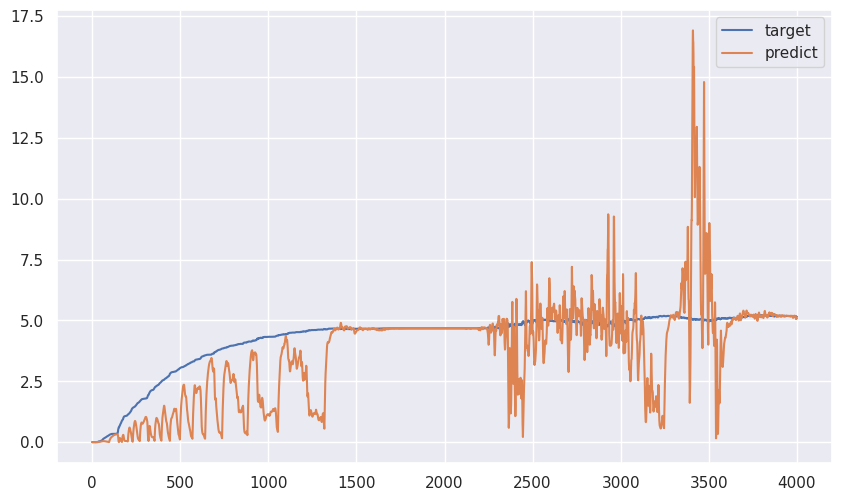

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
         train
MSE   3.029026
MAE   1.056866
MAPE       inf

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS')
qklms_results_test

QKLMS
          train
MSE    0.132281
MAE    0.350413
MAPE  13.723279

## QKLMS AKB Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE    toff_R2
586  0.5      0.6        0.10  0.4  ...  0.005307  0.039476   1.534432   6.796540
585  0.5      0.6        0.10  0.4  ...  0.005308  0.039482   1.534701   6.798869
584  0.5      0.6        0.10  0.4  ...  0.005308  0.039486   1.534859   6.800234
587  0.5      0.6        0.10  0.4  ...  0.005308  0.039508   1.535704   6.807543
164  0.1      0.3        0.05  0.2  ...  0.009934  0.052014   2.003531  11.084876

[5 rows x 14 columns]

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.5, epsilon=0.6, sigma_init=0.10, mu=0.4, K=4)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  20
Final kernel bandwidth:  -736.8940621984833


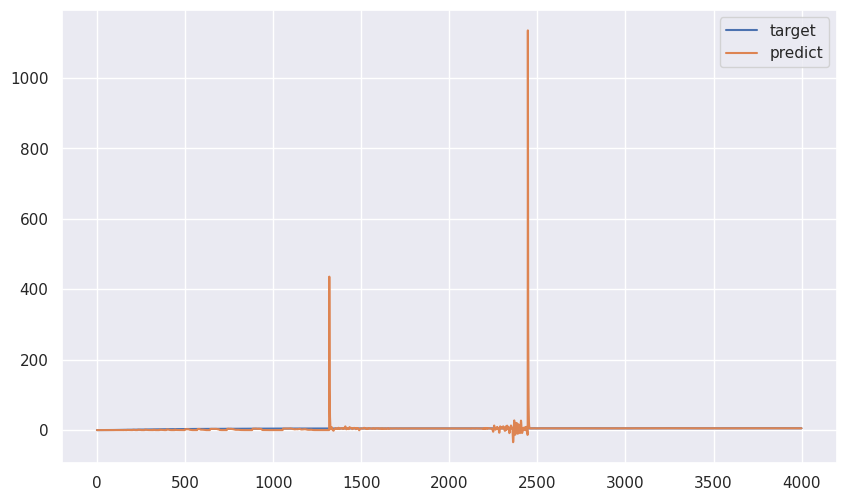

In [ ]:
train_plotter(y,y_pred_train)

-736.8940621984833


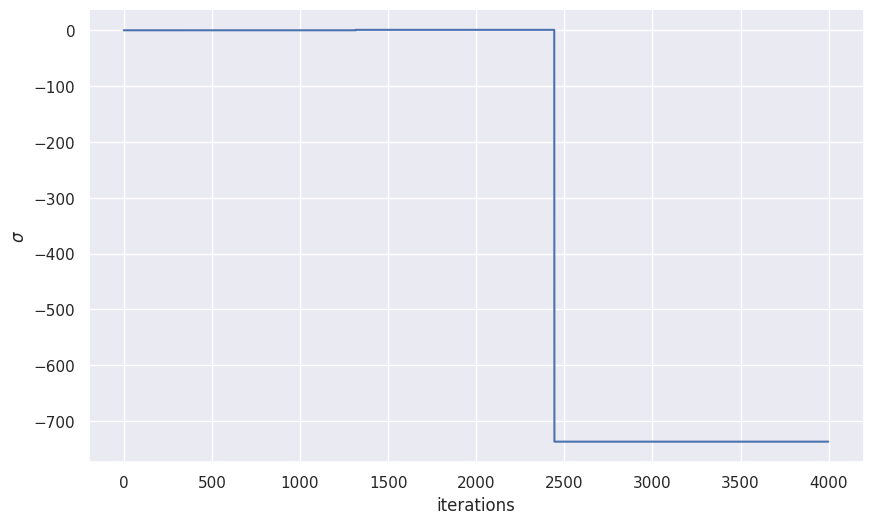

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
           train
MSE   495.242493
MAE     1.908339
MAPE         inf

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB')
akb_results_test

QKLMS_AKB
         train
MSE   0.001780
MAE   0.039158
MAPE  1.534424

## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5, 10, 20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE    toff_R2
27  0.5      0.3    0.1  40  ...  0.025011  0.143118   5.594664  88.354331
43  0.9      0.3    0.1  40  ...  0.025536  0.144828   5.661793  90.517657
31  0.5      0.6    0.1  40  ...  0.025074  0.147245   5.765381  93.830879
30  0.5      0.6    0.1  20  ...  0.025074  0.147245   5.765381  93.830879
47  0.9      0.6    0.1  40  ...  0.025488  0.148467   5.813280  95.442870

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE    toff_R2
27  0.5      0.3    0.1  40  ...  0.025011  0.143118   5.594664  88.354331
43  0.9      0.3    0.1  40  ...  0.025536  0.144828   5.661793  90.517657
31  0.5      0.6    0.1  40  ...  0.025074  0.147245   5.765381  93.830879
30  0.5      0.6    0.1  20  ...  0.025074  0.147245   5.765381  93.830879
47  0.9      0.6    0.1  40  ...  0.025488  0.148467   5.813280  95.442870

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.5, epsilon=0.3, sigma=0.1, FC=40, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  38
Final kernel bandwidth:  3.8829940341282745


In [ ]:
train_plotter(y,y_pred_train)

3.8829940341282745


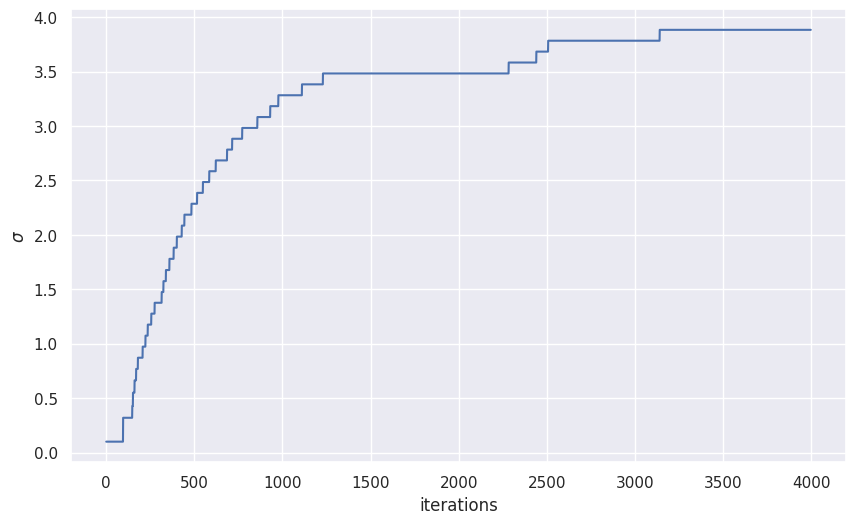

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
          train
MSE    0.001671
MAE    0.021011
MAPE        inf

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', type_='test')
mipv_results_test

QKLMS_MIPV
           test
MSE    0.023469
MAE    0.143823
MAPE   5.634619

## QKLMS AMK Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma   mu  K       MSE       MAE      MAPE        R2  \
944   0.9      0.2    0.2  0.4  8  0.001517  0.033569  1.315508 -4.794506   
969   0.9      0.2    0.3  0.4  8  0.001517  0.033569  1.315508 -4.794506   
919   0.9      0.2    0.1  0.4  8  0.001517  0.033569  1.315508 -4.794506   
994   0.9      0.2    0.4  0.4  8  0.001517  0.033569  1.315508 -4.794506   
1191  0.9      0.6    0.4  0.4  2  0.001571  0.035142  1.377294 -4.997564   

      final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
944         12  0.003362  0.033703   1.315511  5.794506  
969         12  0.003362  0.033703   1.315511  5.794506  
919         12  0.003362  0.033703   1.315511  5.794506  
994         12  0.003362  0.033703   1.315511  5.794506  
1191         4  0.001862  0.035157   1.377294  5.997565

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma   mu  K       MSE       MAE      MAPE        R2  \
919   0.9      0.2    0.1  0.4  8  0.001517  0.033569  1.315508 -4.794506   
944   0.9      0.2    0.2  0.4  8  0.001517  0.033569  1.315508 -4.794506   
969   0.9      0.2    0.3  0.4  8  0.001517  0.033569  1.315508 -4.794506   
994   0.9      0.2    0.4  0.4  8  0.001517  0.033569  1.315508 -4.794506   
1141  0.9      0.6    0.2  0.4  2  0.001571  0.035142  1.377294 -4.997564   

      final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
919         12  0.003362  0.033703   1.315511  5.794506  
944         12  0.003362  0.033703   1.315511  5.794506  
969         12  0.003362  0.033703   1.315511  5.794506  
994         12  0.003362  0.033703   1.315511  5.794506  
1141         4  0.001862  0.035157   1.377294  5.997565

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.9, epsilon=0.2, sigma=0.1, mu=0.4, Ka=8)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  12
Final kernel bandwidth:  0.1


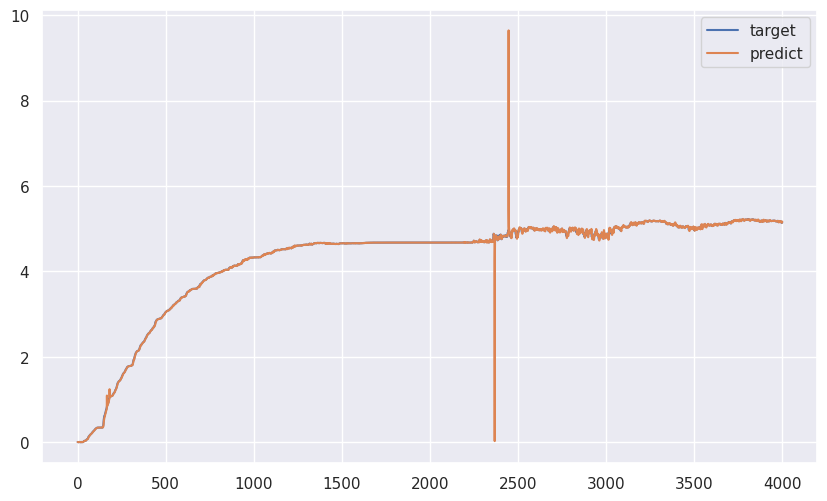

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
         train
MSE   0.011546
MAE   0.012767
MAPE       inf

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
          test
MSE   0.001517
MAE   0.033569
MAPE  1.315508

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  train_samples = 4000
  total_samples = 4200

  data = pd.read_csv('/content/measures_v2.csv')
  sessions = data.profile_id.unique()
  sessions = np.delete(sessions, np.argwhere( (sessions == 47)))
  sessions = np.delete(sessions, np.argwhere( (sessions == 52)))
  sessions = np.delete(sessions, np.argwhere( (sessions == 46)))
  for n in sessions:
    df = get_session(df=data, session_id=n)
    S = df[["stator_yoke"]].to_numpy().reshape(-1,)
    S = z_scorer(S)[:total_samples+10]

    S = S + abs(S.min())
    system_emb = mc_sampler(S, total_samples , 1, embedding=5)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=train_samples/total_samples
    train_size = int(total_samples*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)

    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.2}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (66, 4000, 5) (66, 4000, 1)
Test shapes:  (66, 200, 5) (66, 200, 1)
Total runs:  66


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'motor_temprerature_QKLMS_4000_200.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.5, 'epsilon':0.6, 'sigma_init':0.1, 'mu':0.4, 'K':4}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (66, 4000, 5) (66, 4000, 1)
Test shapes:  (66, 200, 5) (66, 200, 1)
Total runs:  66


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'motor_temprerature_AKB_4000_200.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (66, 4000, 5) (66, 4000, 1)
Test shapes:  (66, 200, 5) (66, 200, 1)
Total runs:  66


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'motor_temprerature_MIPV_4000_200.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

### Curves

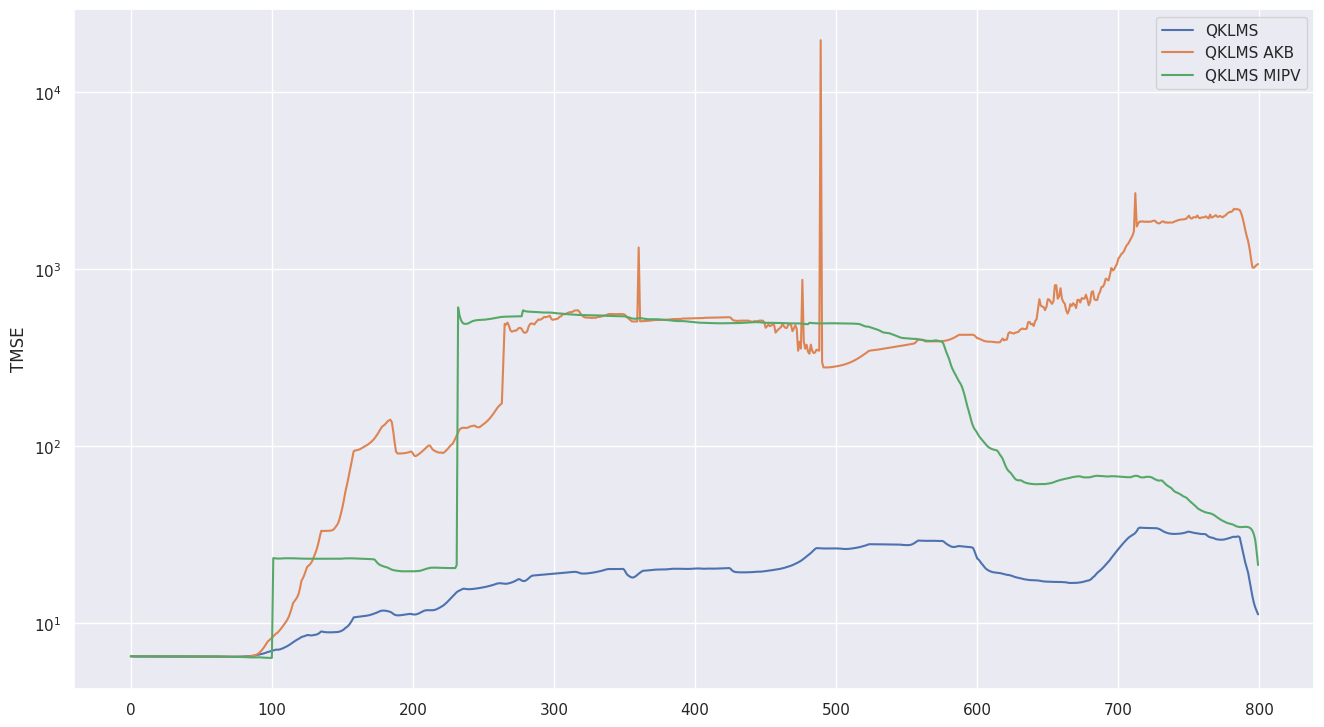

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE)

## Summary

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results,amk_results])

QKLMS   QKLMS_AKB QKLMS_MIPV QKLMS_AMK
         train       train      train     train
MSE   3.029026  495.242493   0.001671  0.011546
MAE   1.056866    1.908339   0.021011  0.012767
MAPE       inf         inf        inf       inf

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test, amk_results_test])

QKLMS QKLMS_AKB QKLMS_MIPV QKLMS_AMK
          train     train       test      test
MSE    0.132281  0.001780   0.023469  0.001517
MAE    0.350413  0.039158   0.143823  0.033569
MAPE  13.723279  1.534424   5.634619  1.315508

- Gana AKB. MIPV tiene el peor desempeño.
- El sigma para AKB sube, el sigma para MIPV baja.

#Internet traffic dataset

Chen, B., Liang, J., Zheng, N., & Príncipe, J. C. (2016). Kernel least mean square with adaptive kernel size. Neurocomputing, 191, 95–106. doi:10.1016/j.neucom.2016.01.004

[http://www3. dsi.uminho.pt/pcortez/series/A5M.txt](https://)

Cortez, P., Rio, M., Rocha, M. and Sousa, P. (2012), Multi-scale Internet traffic forecasting using neural networks and time series methods. Expert Systems, 29: 143-155. https://doi-org.ezproxy.utp.edu.co/10.1111/j.1468-0394.2010.00568.x


## Data preparation

In [ ]:
f = open('/content/internet_traffic_dataset.txt', 'r+')
my_file_data = f.read().split("\n")
f.close()
internet_db = np.array(my_file_data, dtype=np.float64)[:4205]
S = z_scorer(internet_db)
system_emb = mc_sampler(S, 4200 , 1, embedding=5)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=4000/4200
train_size = int(4200*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (4000, 5) (4000, 1)
test  (200, 5) (200, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.3, 0.6, 0.8,1.0], 'sigma': [0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
17  0.5      0.3   0.15  0.050320  ...  0.054919  0.151040  111.412021  0.048280
2   0.1      0.3   0.20  0.029718  ...  0.036975  0.113452  118.156384  0.033589
3   0.1      0.3   0.35  0.012771  ...  0.025438  0.080247  123.277435  0.024555
39  0.9      0.6   0.35  0.043554  ...  0.043785  0.167078  126.951601  0.037468
6   0.1      0.6   0.20  0.108925  ...  0.109018  0.236288  132.948544  0.093136

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
7   0.1      0.6   0.35  0.012682  ...  0.013457  0.079527  198.069206  0.011729
23  0.5      0.6   0.35  0.024130  ...  0.024546  0.121351  186.278860  0.021094
11  0.1      0.8   0.35  0.025529  ...  0.025676  0.121219  243.443212  0.021975
3   0.1      0.3   0.35  0.012771  ...  0.025438  0.080247  123.277435  0.024555
2   0.1      0.3   0.20  0.029718  ...  0.036975  0.113452  118.156384  0.033589

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.6, sigma=0.35)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
qklms_model = filt_trainned
ptr_qklms = y_pred_train
pts_qklms = y_pred_test


Training complete

Final codebook size:  18
Final kernel bandwidth:  0.35


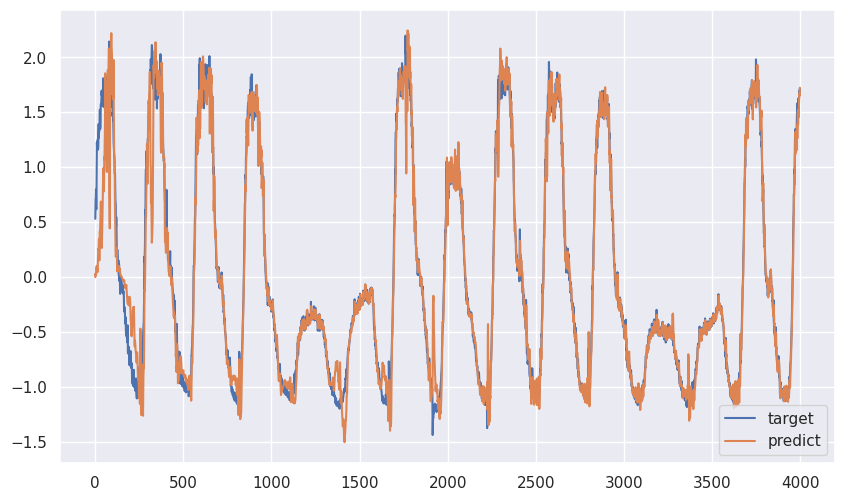

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
            train
MSE      0.044946
MAE      0.117585
MAPE  1046.378118

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', type_='test')
qklms_results_test

QKLMS_MIPV
            test
MSE     0.012682
MAE     0.079399
MAPE  198.069206

In [ ]:
qklms_model = filt_trainned

## QKLMS AKB Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [ 0.3, 0.6, 0.8, 0.1], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
19  0.1      0.3        0.10  0.1  ...  0.024374  0.082315   97.573447  0.023755
18  0.1      0.3        0.10  0.1  ...  0.024395  0.082541   98.869303  0.023771
17  0.1      0.3        0.10  0.1  ...  0.024405  0.082650   99.779665  0.023779
16  0.1      0.3        0.10  0.1  ...  0.024410  0.082701  100.248815  0.023782
35  0.1      0.3        0.15  0.1  ...  0.024441  0.083051  102.000044  0.023805

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
119  0.1      0.6        0.15  0.2  ...  0.012226  0.082583  119.816568  0.010700
118  0.1      0.6        0.15  0.2  ...  0.012412  0.083565  120.713703  0.010856
117  0.1      0.6        0.15  0.2  ...  0.012466  0.083827  121.031421  0.010901
116  0.1      0.6        0.15  0.2  ...  0.012472  0.083860  121.076543  0.010906
129  0.1      0.6        0.20  0.1  ...  0.014159  0.091512  123.833939  0.012317

[5 rows x 14 columns]

## QKLMS AKB Filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.15, mu=0.2, K=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
akb_model = filt_trainned
ptr_akb = y_pred_train
pts_akb = y_pred_test


Training complete

Final codebook size:  18
Final kernel bandwidth:  0.5803114695109012


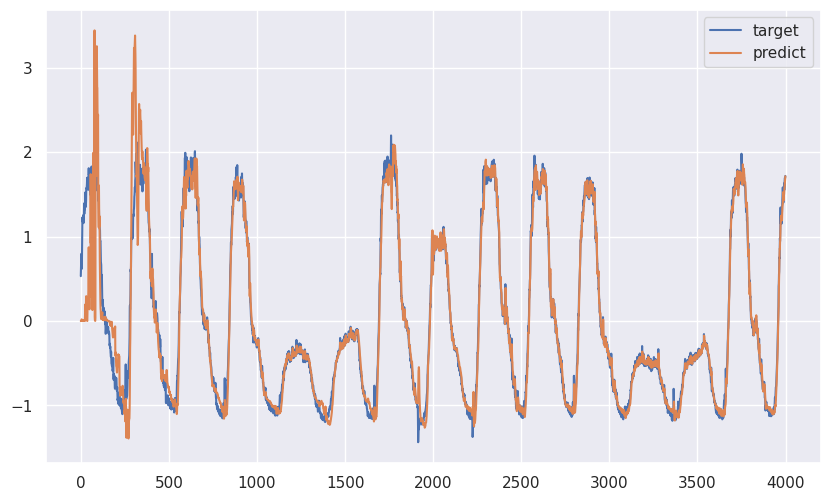

In [ ]:
train_plotter(y,y_pred_train)

0.5803114695109012


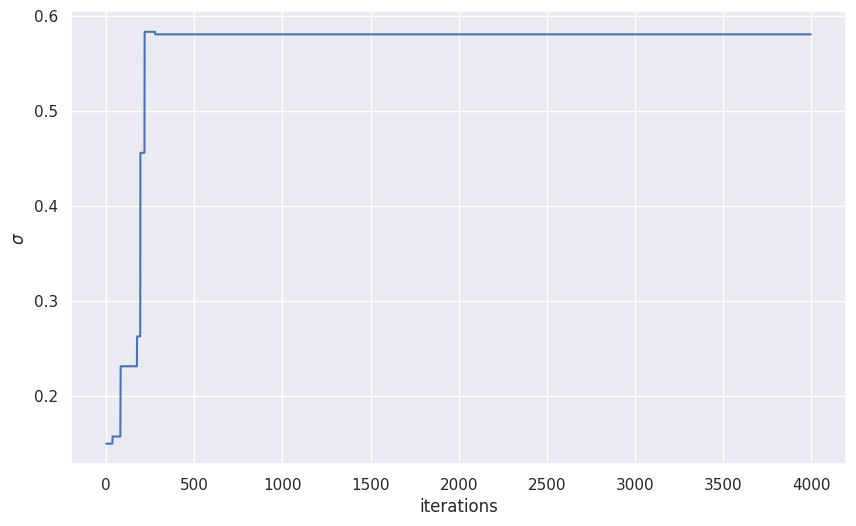

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
            train
MSE      0.067612
MAE      0.122177
MAPE  1130.826558

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB', type_='test')
akb_results_test

QKLMS_AKB
            test
MSE     0.011367
MAE     0.082460
MAPE  119.816568

In [ ]:
akb_model = filt_trainned

## QKLMS MIPV Grid Search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.3, 0.6, 0.8, 0.1], 'sigma': [0.1], 'FC':[5, 10, 20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
12  0.1      0.1    0.1   5  ...  0.231943  0.242860  117.208915  0.231891
28  0.5      0.1    0.1   5  ...  0.236850  0.291762  117.819284  0.235481
16  0.5      0.3    0.1   5  ...  0.069784  0.193597  118.417021  0.060688
13  0.1      0.1    0.1  10  ...  0.231942  0.242521  119.274668  0.231890
0   0.1      0.3    0.1   5  ...  0.024208  0.079428  121.458958  0.023631

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
4  0.1      0.6    0.1   5  ...  0.022872  0.125340  182.840098  0.019674
0  0.1      0.3    0.1   5  ...  0.024208  0.079428  121.458958  0.023631
1  0.1      0.3    0.1  10  ...  0.026514  0.099141  126.674988  0.025372
8  0.1      0.8    0.1   5  ...  0.032887  0.158275  425.863006  0.028123
2  0.1      0.3    0.1  20  ...  0.036561  0.153130  525.408439  0.033256

[5 rows x 14 columns]

## QKLMS MIPV Filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
mipv_model = filt_trainned
ptr_mipv = y_pred_train
pts_mipv = y_pred_test


Training complete

Final codebook size:  18
Final kernel bandwidth:  1.0406130035222478


In [ ]:
train_plotter(y,y_pred_train)

1.0406130035222478


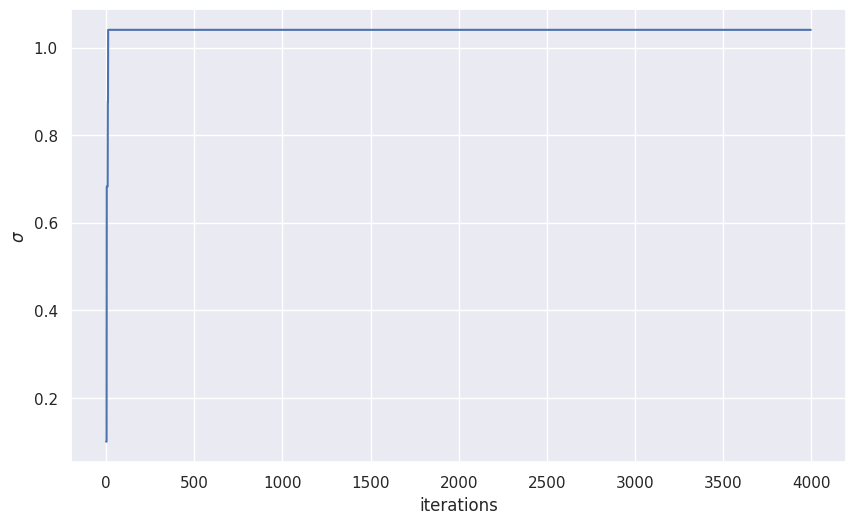

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
            train
MSE      0.019327
MAE      0.087753
MAPE  1143.115707

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', type_='test')
mipv_results_test

QKLMS_MIPV
            test
MSE     0.022419
MAE     0.125165
MAPE  179.394514

In [ ]:
mipv_model = filt_trainned

## QKLMS AMK Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma    mu  K       MSE       MAE        MAPE        R2  \
323  0.1      0.6    0.1  0.60  6  0.017772  0.109032  148.956313  0.984822   
348  0.1      0.6    0.2  0.60  6  0.017772  0.109032  148.956313  0.984822   
373  0.1      0.6    0.3  0.60  6  0.017772  0.109032  148.956313  0.984822   
398  0.1      0.6    0.4  0.60  6  0.017772  0.109032  148.956313  0.984822   
254  0.1      0.3    0.3  0.05  8  0.016218  0.103782  160.155301  0.986149   

     final_CB  toff_MSE  toff_MAE   toff_MAPE   toff_R2  
323        10  0.017947  0.109061  148.956313  0.015383  
348        10  0.017947  0.109061  148.956313  0.015383  
373        10  0.017947  0.109061  148.956313  0.015383  
398        10  0.017947  0.109061  148.956313  0.015383  
254        39  0.018923  0.104239  160.155301  0.016939

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma    mu  K       MSE       MAE        MAPE        R2  \
176  0.1      0.2    0.4  0.05  2  0.014748  0.091953  582.110545  0.987404   
101  0.1      0.2    0.1  0.05  2  0.014748  0.091953  582.110545  0.987404   
126  0.1      0.2    0.2  0.05  2  0.014748  0.091953  582.110545  0.987404   
151  0.1      0.2    0.3  0.05  2  0.014748  0.091953  582.110545  0.987404   
394  0.1      0.6    0.4  0.40  8  0.017137  0.103782  171.106845  0.985364   

     final_CB  toff_MSE  toff_MAE   toff_MAPE   toff_R2  
176        29  0.016434  0.092238  582.110545  0.014533  
101        29  0.016434  0.092238  582.110545  0.014533  
126        29  0.016434  0.092238  582.110545  0.014533  
151        29  0.016434  0.092238  582.110545  0.014533  
394        13  0.017442  0.103833  171.106845  0.014992

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.1, epsilon=0.2, sigma=0.4, mu=0.05, Ka=2)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  29
Final kernel bandwidth:  0.4


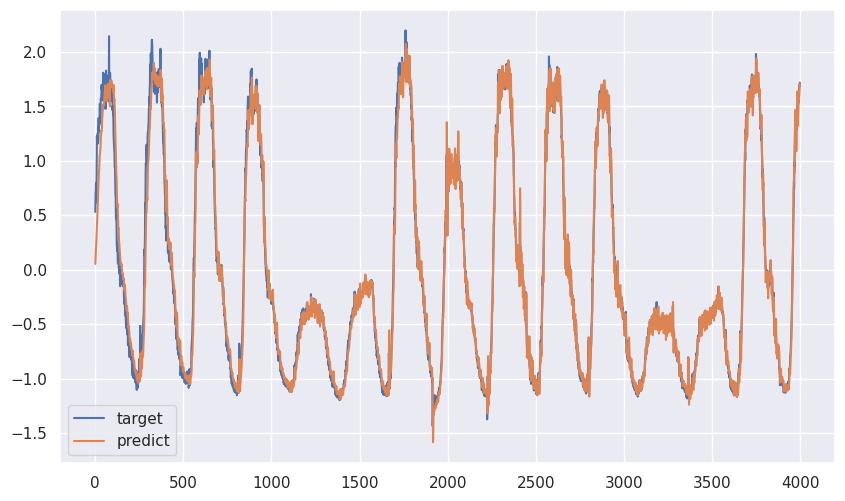

In [ ]:
train_plotter(y,y_pred_train)

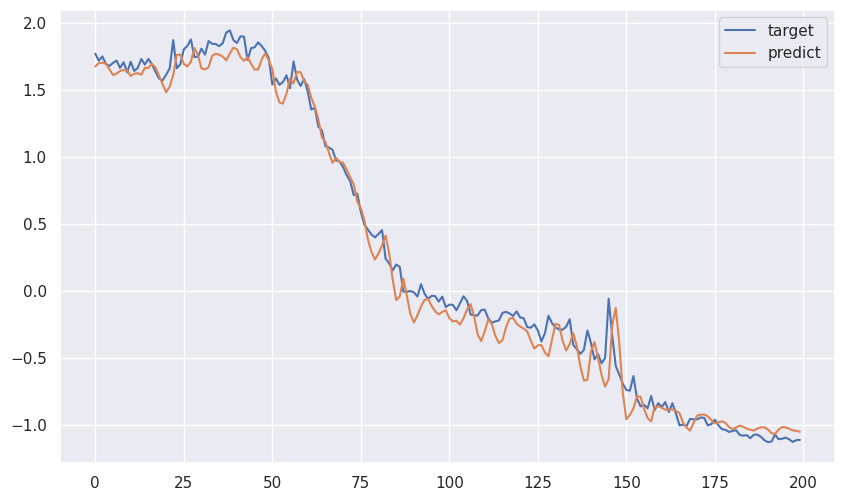

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
            train
MSE      0.016551
MAE      0.086763
MAPE  1360.647388

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
            test
MSE     0.014748
MAE     0.091953
MAPE  582.110545

## TMSE Calculation

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for n in range(mc_runs):
    f = open('/content/internet_traffic_dataset.txt', 'r+')
    my_file_data = f.read().split("\n")
    f.close()
    internet_db = np.array(my_file_data, dtype=np.float64)[n:n+4205]
    S = z_scorer(internet_db)
    system_emb = mc_sampler(S, 4200 , 1, embedding=5)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=4000/4200
    train_size = int(4200*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)

    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.35}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'internet_traffic_QKLMS_4000_200.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.15, 'mu':0.2, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'internet_traffic_AKB_4000_200.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'internet_traffic_MIPV_200.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.1, 'epsilon':0.3, 'sigma':0.4, 'mu':0.05, 'K':2}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'sunspot_AMK_1500_100.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

## TMSE Curves

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE,AKB_TMSE)

## Summary

### Scores

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results,amk_results])

QKLMS    QKLMS_AKB   QKLMS_MIPV    QKLMS_AMK
            train        train        train        train
MSE      0.044946     0.067612     0.019327     0.016551
MAE      0.117585     0.122177     0.087753     0.086763
MAPE  1046.378118  1130.826558  1143.115707  1360.647388

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test,amk_results_test])

QKLMS_MIPV   QKLMS_AKB  QKLMS_MIPV   QKLMS_AMK
            test        test        test        test
MSE     0.012682    0.011367    0.022419    0.014748
MAE     0.079399    0.082460    0.125165    0.091953
MAPE  198.069206  119.816568  179.394514  582.110545

In [ ]:
final_TMSE(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE)

### Codebook & sigma changes over time

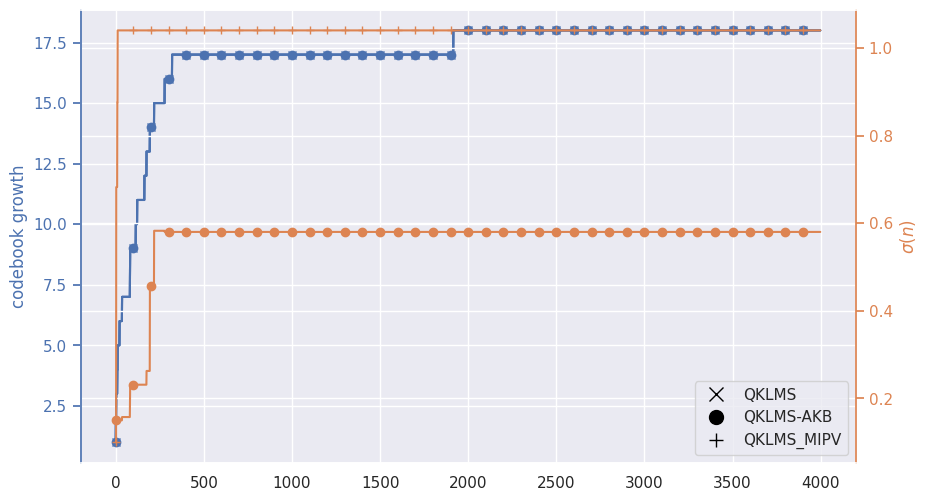

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model,  mark_steps=100, tikz_name="InternetTraffic_CB.tex")

### Train & test prediction plots

In [ ]:
prediction_plotter_multiple(ptr_qklms, ptr_akb, ptr_mipv, y, tikz="internet_traffic_train_pred.tex")

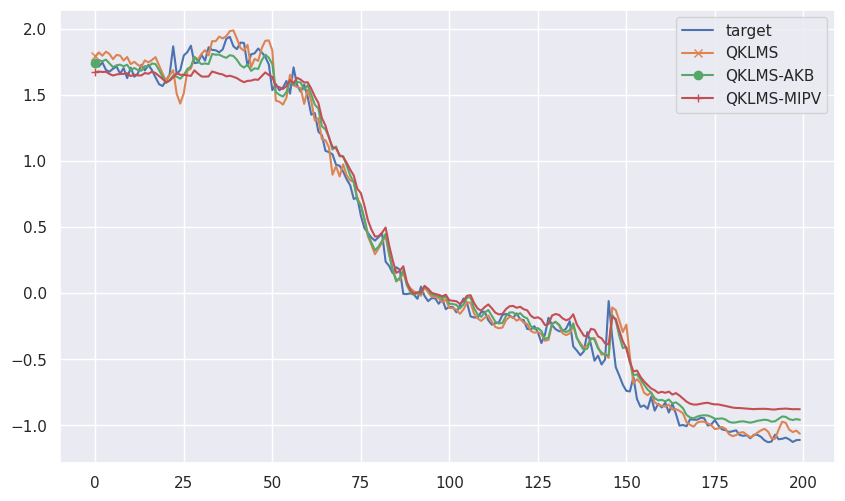

In [ ]:
prediction_plotter_multiple(pts_qklms, pts_akb, pts_mipv, ytest, tikz="internet_traffic_train_pred.tex")

In [ ]:
ape_qklms = APE(y,ypred)
TMSE_plot(ape_qklms,)

- QKLMS tiene mejor MAPE que los metodos adaptativos, pierde en las otras metricas.

- MIPV tiene el mejor desempeño general y le gana en todo a AKB.




# Mackey Glass Times-Series
Shen, M., Feng, W., Huang, G., Qi, L., Liu, Y., &#38; Wang, S. (2022). Combined multiple random features least mean square algorithm for online applications. <i>IET Signal Processing</i>, <i>16</i>(4), 391–399. https://doi.org/10.1049/SIL2.12102

## Data prepareation

In [ ]:
!git clone https://github.com/manu-mannattil/nolitsa.git
!pip install ./nolitsa

Cloning into 'nolitsa'...
remote: Enumerating objects: 823, done.
remote: Total 823 (delta 0), reused 0 (delta 0), pack-reused 823
Receiving objects: 100% (823/823), 432.86 KiB | 18.04 MiB/s, done.
Resolving deltas: 100% (546/546), done.
Processing ./nolitsa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=31147 sha256=0f31ff329ee013ba4dcb15f5bf9a33b449ce32982f91480194d1a33ab58b89d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-d19xy487/wheels/81/d4/a9/b51abd0469117366be40165d7aeeaacfcb61bbedbeda3fade8
Successfully built nolitsa


In [ ]:
from nolitsa import data
samples = 4200
x = data.mackey_glass(tau=23.0, sample=0.46, n=1000)[:4205]
S = z_scorer(x)
system_emb = mc_sampler(S, 4200 , 1, embedding=5)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=4000/4200
train_size = int(samples*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (4000, 5) (4000, 1)
test  (200, 5) (200, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
4   0.1      0.1   0.35  0.001587  ...  0.082515  0.087926  11.065814  0.082529
3   0.1      0.1   0.20  0.001366  ...  0.082511  0.087174  11.612377  0.082521
14  0.1      0.3   0.35  0.002198  ...  0.014171  0.040003  12.584189  0.014323
2   0.1      0.1   0.15  0.002742  ...  0.082546  0.090481  12.832977  0.082586
23  0.5      0.1   0.20  0.003181  ...  0.082561  0.091886  12.837567  0.082616

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
19  0.1      0.6   0.35  0.006710  ...  0.008221  0.064684  57.492323  0.010385
14  0.1      0.3   0.35  0.002198  ...  0.014171  0.040003  12.584189  0.014323
13  0.1      0.3   0.20  0.004226  ...  0.014624  0.049389  17.396855  0.015160
34  0.5      0.3   0.35  0.008432  ...  0.016343  0.079073  23.498546  0.018185
33  0.5      0.3   0.20  0.011654  ...  0.018216  0.082166  26.909282  0.021290

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.6, sigma=0.35)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
qklms_model = filt_trainned


Training complete

Final codebook size:  22
Final kernel bandwidth:  0.35


In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
            train
MSE      0.069874
MAE      0.126950
MAPE  1043.651383

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS', type_='test')
qklms_results_test

QKLMS
           test
MSE    0.012204
MAE    0.076854
MAPE  35.777272

## QKLMS AKB search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
92   0.1      0.2        0.05  0.6  ...  0.027003  0.030604   4.624654  0.027005
93   0.1      0.2        0.05  0.6  ...  0.027003  0.030604   4.624679  0.027005
94   0.1      0.2        0.05  0.6  ...  0.027003  0.030643   4.664752  0.027005
111  0.1      0.2        0.10  0.6  ...  0.027003  0.030607   4.667418  0.027005
95   0.1      0.2        0.05  0.6  ...  0.027003  0.030647   4.669259  0.027005

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
291  0.1      0.6        0.20  0.1  ...  0.004994  0.030901  17.047060  0.005203
290  0.1      0.6        0.20  0.1  ...  0.004999  0.031124  17.222238  0.005211
307  0.1      0.6        0.35  0.1  ...  0.005006  0.031455  17.210179  0.005225
306  0.1      0.6        0.35  0.1  ...  0.005007  0.031485  17.169306  0.005227
288  0.1      0.6        0.20  0.1  ...  0.005009  0.031562  17.295343  0.005229

[5 rows x 14 columns]

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.2, mu=0.1, K=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
akb_model = filt_trainned


Training complete

Final codebook size:  22
Final kernel bandwidth:  0.4051942675430442


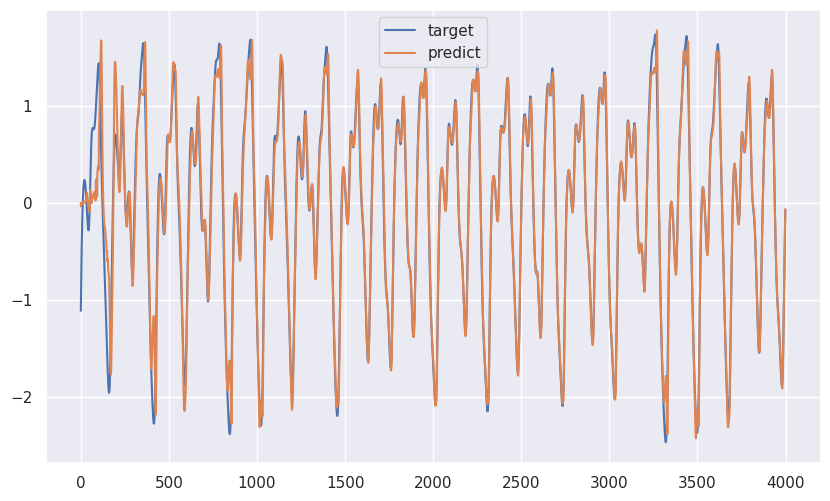

In [ ]:
train_plotter(y,y_pred_train)

0.8053841049486912


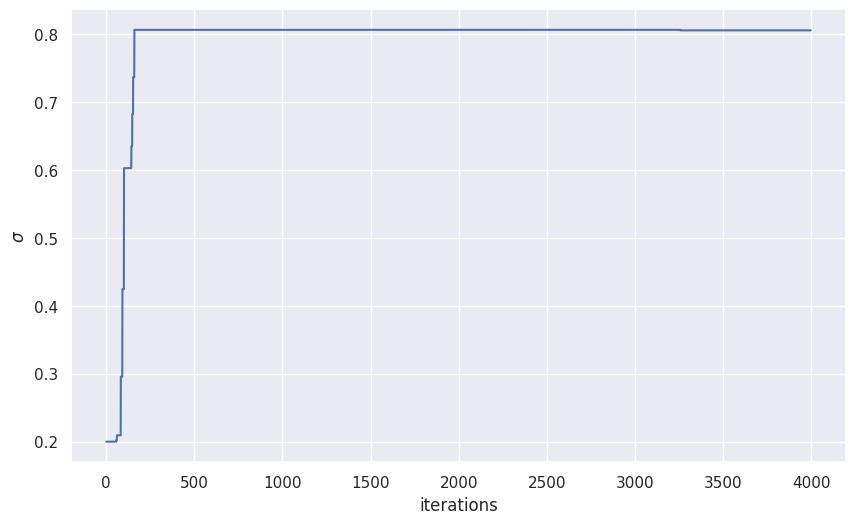

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
            train
MSE      0.063551
MAE      0.116833
MAPE  1148.622372

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB', type_='test')
akb_results_test

QKLMS_AKB
           test
MSE    0.007176
MAE    0.063120
MAPE  33.494602

## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5, 10, 20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
5  0.1      0.2    0.1  10  ...  0.027003  0.030555   4.652041  0.027005
3  0.1      0.1    0.1  40  ...  0.082501  0.083731   4.726212  0.082502
6  0.1      0.2    0.1  20  ...  0.027003  0.030648   4.739736  0.027005
2  0.1      0.1    0.1  20  ...  0.082501  0.083913   5.186194  0.082502
9  0.1      0.3    0.1  10  ...  0.014007  0.021934   5.633201  0.014013

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
12  0.1      0.6    0.1   5  ...  0.005282  0.038388  21.312082  0.005717
28  0.5      0.6    0.1   5  ...  0.006786  0.047703  16.442806  0.008189
9   0.1      0.3    0.1  10  ...  0.014007  0.021934   5.633201  0.014013
10  0.1      0.3    0.1  20  ...  0.014016  0.025966   9.444871  0.014031
25  0.5      0.3    0.1  10  ...  0.014026  0.027719   8.011642  0.014049

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
mipv_model = filt_trainned


Training complete

Final codebook size:  22
Final kernel bandwidth:  1.0705033773147066


In [ ]:
train_plotter(y,y_pred_train)

1.1981737880740702


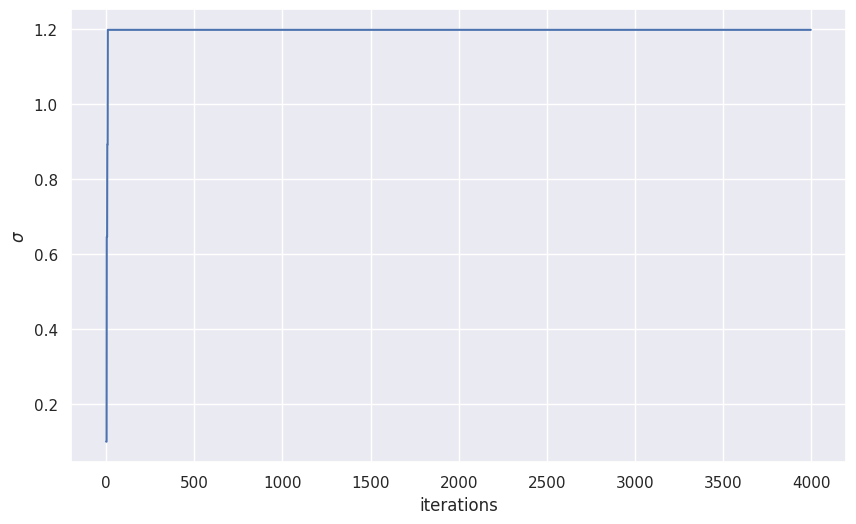

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
            train
MSE      0.028940
MAE      0.093412
MAPE  1739.413043

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', type_='test')
mipv_results_test

QKLMS_MIPV
           test
MSE    0.007804
MAE    0.068423
MAPE  26.585058

## QKLMS AMK Grid Search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma    mu  K       MSE       MAE      MAPE        R2  \
253  0.1      0.3    0.3  0.05  6  0.002247  0.035817  28.01493  0.994519   
203  0.1      0.3    0.1  0.05  6  0.002247  0.035817  28.01493  0.994519   
228  0.1      0.3    0.2  0.05  6  0.002247  0.035817  28.01493  0.994519   
278  0.1      0.3    0.4  0.05  6  0.002247  0.035817  28.01493  0.994519   
102  0.1      0.2    0.1  0.05  4  0.001562  0.030146  44.83618  0.996188   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
253        42  0.010738  0.037325  28.014932  0.011845  
203        42  0.010738  0.037325  28.014932  0.011845  
228        42  0.010738  0.037325  28.014932  0.011845  
278        42  0.010738  0.037325  28.014932  0.011845  
102        42  0.010616  0.031922  44.836181  0.011171

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma    mu  K       MSE       MAE      MAPE        R2  \
337  0.1      0.6    0.2  0.20  4  0.003878  0.054049  67.63284  0.990539   
362  0.1      0.6    0.3  0.20  4  0.003878  0.054049  67.63284  0.990539   
387  0.1      0.6    0.4  0.20  4  0.003878  0.054049  67.63284  0.990539   
312  0.1      0.6    0.1  0.20  4  0.003878  0.054049  67.63284  0.990539   
102  0.1      0.2    0.1  0.05  4  0.001562  0.030146  44.83618  0.996188   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
337        14  0.005224  0.054162  67.632840  0.010088  
362        14  0.005224  0.054162  67.632840  0.010088  
387        14  0.005224  0.054162  67.632840  0.010088  
312        14  0.005224  0.054162  67.632840  0.010088  
102        42  0.010616  0.031922  44.836181  0.011171

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.1, epsilon=0.6, sigma=0.2, mu=0.2, Ka=4)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  13
Final kernel bandwidth:  0.2


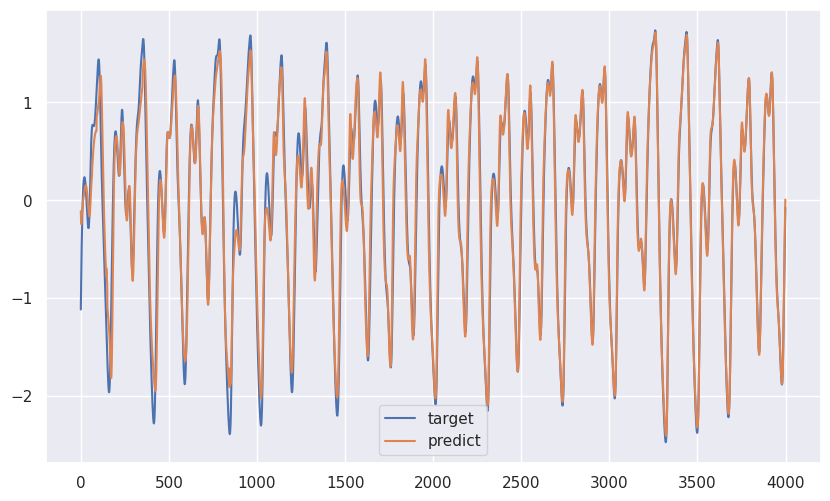

In [ ]:
train_plotter(y,y_pred_train)

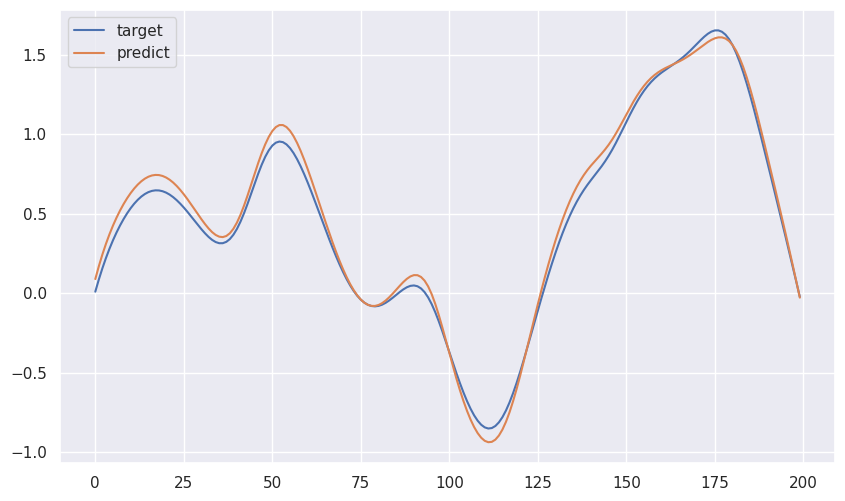

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
            train
MSE      0.018025
MAE      0.080686
MAPE  2185.659422

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
           test
MSE    0.002065
MAE    0.037742
MAPE  39.254183

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    from nolitsa import data
    samples = 4200
    x = data.mackey_glass(tau=23.0, sample=0.46, n=1000)[:4205]
    S = z_scorer(x)
    system_emb = mc_sampler(S, 4200 , 1, embedding=5)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=4000/4200
    train_size = int(samples*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.35}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive +'mickey_glass_QKLMS_4000_200.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.2, 'mu':0.1, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'mickey_glass_AKB_4000_200.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'mickey_glass_MIPV_4000_200.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.2, 'mu':0.2, 'K':4}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'mickey_glass_AMK_2000_200.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

### Curves

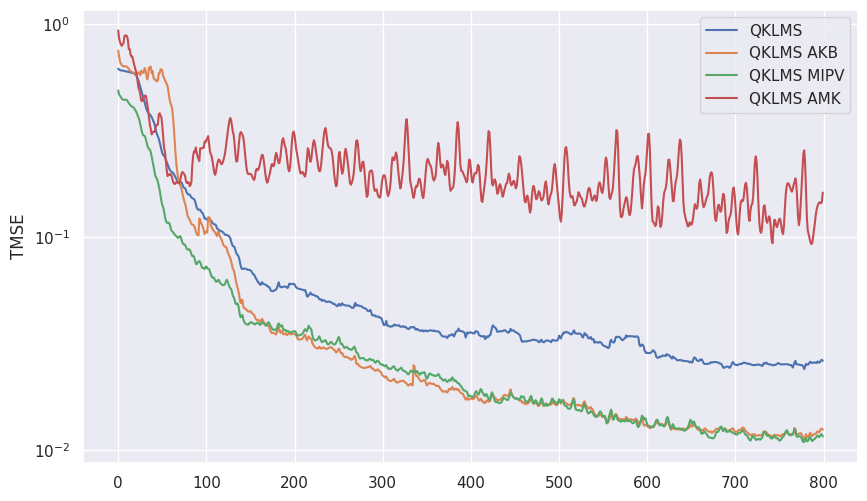

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE)

##Summary

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results,amk_results])

QKLMS    QKLMS_AKB   QKLMS_MIPV    QKLMS_AMK
            train        train        train        train
MSE      0.069874     0.063551     0.028940     0.018025
MAE      0.126950     0.116833     0.093412     0.080686
MAPE  1043.651383  1148.622372  1739.413043  2185.659422

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test, amk_results_test])

QKLMS  QKLMS_AKB QKLMS_MIPV  QKLMS_AMK
           test       test       test       test
MSE    0.012204   0.007176   0.007804   0.002065
MAE    0.076854   0.063120   0.068423   0.037742
MAPE  35.777272  33.494602  26.585058  39.254183

In [ ]:
final_TMSE(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE)

- AKB tiene el mejor desempeño,  seguido de MIPV
- Las cuervas de TMSE se ven muy parejas

### Codebook & sigma changes over time

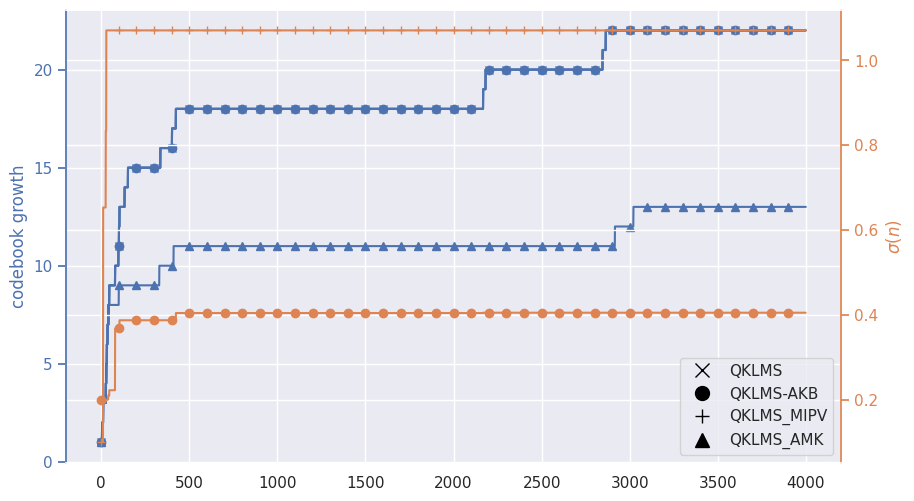

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model, amk_model, mark_steps=100, tikz_name="MackeyGlass_CB.tex")

# Nonlinear System

Liu, X., Song, C., & Pang, Z. (2022). Kernel recursive maximum correntropy with variable center. Signal Processing, 191 doi:10.1016/j.sigpro.2021.108364

\\

$$ z(n) = x(n) - 0.8x(n-1) + 1.9x(n-3) + 0.95x^2(n) + 1.1x(n) x(n-2) -0.63x(n-2)x(n-3) + \nu(n)$$


## Data preparations

In [ ]:
 import random
import numpy as np
def nonlinear_system(samples):
  """
  Liu, X., Song, C., & Pang, Z. (2022). Kernel recursive maximum correntropy with variable center.
  Signal Processing, 191 doi:10.1016/j.sigpro.2021.108364
  """
  # noise
  seed = random.randint(0, 4000)
  rng = np.random.default_rng(seed)
  mean = 0.2
  var = 0.1
  noise = rng.normal(mean, var**0.5, samples+3)

  # input signal
  seed = random.randint(0, 4000)
  rng = np.random.default_rng(seed)
  mean = 0
  var = 1
  u = rng.normal(mean, var**0.5, samples+3)

  d = [u[n] - 0.8*u[n-1] + 1.9*u[n-3] + 0.95*u[n]**2 + 1.1*u[n]*u[n-2] - 0.63*u[n-2]*u[n-3] + noise[n] for n in range(3,samples+3)]
  return u[3:],np.array(d)

In [ ]:
u,d = nonlinear_system(1105)
X = signal_embedder_dual(u,embedding=5)
y = d[5:].reshape(-1,1)
samples = 1100
train_portion=1000/1100
train_size = int(samples*train_portion)
Xtrain,ytrain = X[:train_size],y[:train_size].reshape(-1,1)
Xtest,ytest = X[train_size:],y[train_size:].reshape(-1,1)

print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (1000, 5) (1000, 1)
test  (100, 5) (100, 1)


In [ ]:
X = Xtrain
y = ytrain

## Filtering

### QKLMS

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.5, 1, 1,5, 2, 2.5], 'sigma': [1, 2, 4, 6, 8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/90 [00:00<?, ?it/s]

eta  epsilon  sigma        MSE  ...   toff_MSE  toff_MAE   toff_MAPE   toff_R2
15  0.1      5.0      1  17.281233  ...  17.281234  2.942428  184.582022  1.324642
21  0.1      2.0      2   8.362517  ...   8.362747  1.916537  198.439869  0.643991
0   0.1      0.5      1  10.241680  ...  10.280105  2.311468  201.406954  1.185256
5   0.1      1.0      1  10.376448  ...  10.383699  2.198196  206.806322  0.884962
10  0.1      1.0      1  10.376448  ...  10.383699  2.198196  206.806322  0.884962

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
21  0.1      2.0      2  8.362517  ...  8.362747  1.916537  198.439869  0.643991
22  0.1      2.0      4  8.409767  ...  8.409995  2.071579  288.160172  0.647596
27  0.1      2.5      4  8.639928  ...  8.639964  2.103860  267.117926  0.662735
23  0.1      2.0      6  8.751928  ...  8.752147  2.189649  328.686172  0.673707
28  0.1      2.5      6  8.803809  ...  8.803845  2.189767  313.758031  0.675288

[5 rows x 12 columns]

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=2, sigma=2)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)


Training complete

Final codebook size:  62
Final kernel bandwidth:  2


In [ ]:
train_plotter(ytrain,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
            train
MSE      5.644919
MAE      1.689792
MAPE  5551.561886

### QKLMS AKB

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.5, 1, 1,5, 2, 2.5], 'sigma_init': [1, 2, 4, 6, 8], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1440 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...   toff_MSE  toff_MAE  toff_MAPE   toff_R2
972  0.9      0.5           1  0.6  ...  14.760819  2.828803  96.709620  1.436685
656  0.5      1.0           2  0.1  ...  15.193114  2.777510  97.502193  1.227149
576  0.5      1.0           2  0.1  ...  15.193114  2.777510  97.502193  1.227149
698  0.5      1.0           6  0.4  ...  15.224854  2.779491  97.566998  1.229458
618  0.5      1.0           6  0.4  ...  15.224854  2.779491  97.566998  1.229458

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
361  0.1      2.0           4  0.4  ...  8.151552  1.927018  209.451755  0.627879
362  0.1      2.0           4  0.4  ...  8.152621  1.922367  206.400380  0.627961
363  0.1      2.0           4  0.4  ...  8.158662  1.947526  222.805546  0.628422
356  0.1      2.0           4  0.2  ...  8.234962  1.998624  253.114883  0.634242
358  0.1      2.0           4  0.2  ...  8.274317  2.014449  262.657894  0.637244

[5 rows x 14 columns]

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=2, sigma_init=4, mu=0.4, K=2)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)


Training complete

Final codebook size:  62
Final kernel bandwidth:  2.6738761223480814


In [ ]:
train_plotter(y,y_pred_train)

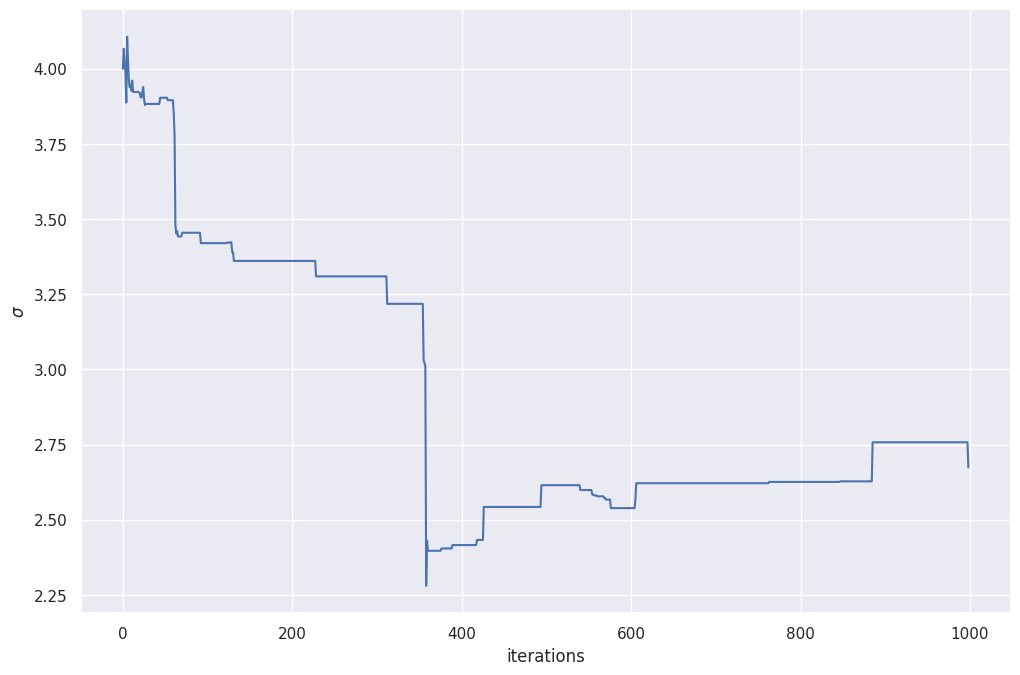

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
            train
MSE      5.542624
MAE      1.675702
MAPE  6800.999758

### QKLMS MIPV

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.5, 1, 1,5, 2, 2.5], 'sigma': [0.1], 'FC':[5,10,20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/72 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
17  0.1      2.0    0.1  10  ...  8.165407  1.954701  222.747227  0.628936
7   0.1      1.0    0.1  40  ...  8.512311  2.053494  224.268208  0.758546
11  0.1      1.0    0.1  40  ...  8.512311  2.053494  224.268208  0.758546
6   0.1      1.0    0.1  20  ...  8.509944  2.054144  224.992897  0.758390
10  0.1      1.0    0.1  20  ...  8.509944  2.054144  224.992897  0.758390

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
17  0.1      2.0    0.1  10  ...  8.165407  1.954701  222.747227  0.628936
16  0.1      2.0    0.1   5  ...  8.170461  1.962578  228.406886  0.629322
18  0.1      2.0    0.1  20  ...  8.177185  1.969092  232.671022  0.629835
19  0.1      2.0    0.1  40  ...  8.184624  1.975066  236.632692  0.630402
20  0.1      2.5    0.1   5  ...  8.625263  2.070665  241.994857  0.661609

[5 rows x 14 columns]

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=2, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)


Training complete

Final codebook size:  62
Final kernel bandwidth:  2.7920029012575567


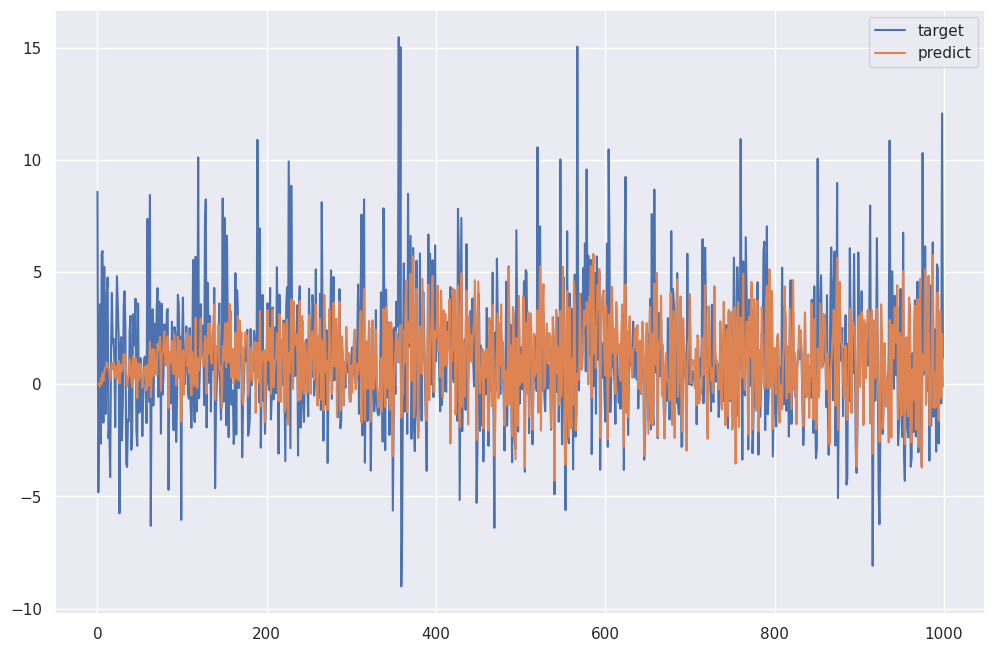

In [ ]:
train_plotter(y,y_pred_train)

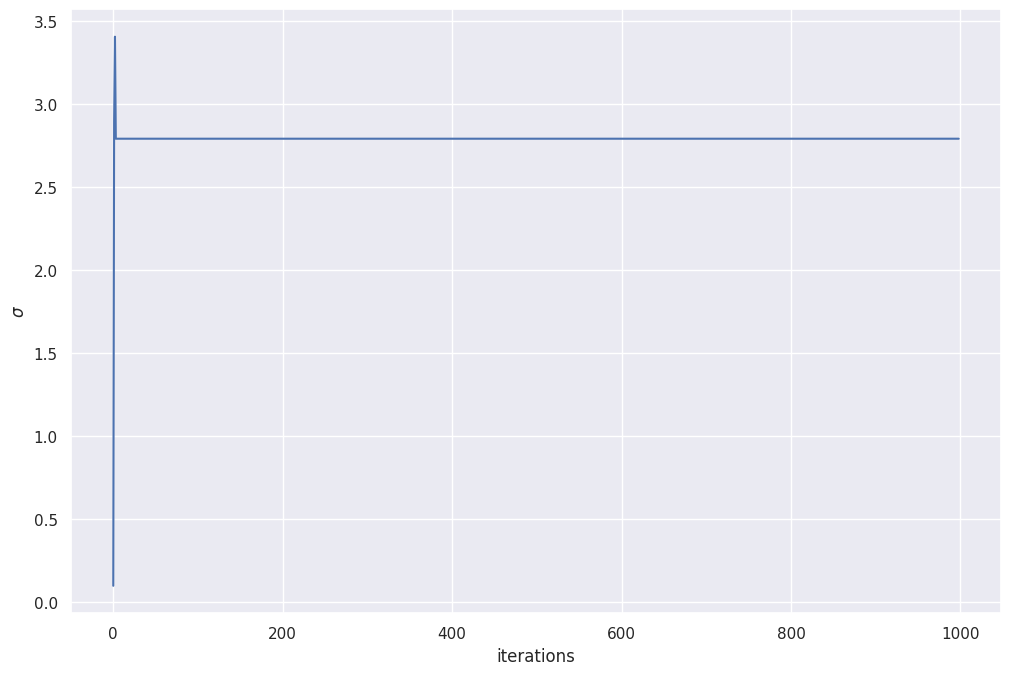

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
            train
MSE      5.490294
MAE      1.661579
MAPE  5952.182652

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    u,d = nonlinear_system(1105)
    X = signal_embedder_dual(u,embedding=5)
    y = d[5:].reshape(-1,1)
    samples = 1100
    train_portion=1000/1100
    train_size = int(samples*train_portion)
    Xtrain,ytrain = X[:train_size],y[:train_size].reshape(-1,1)
    Xtest,ytest = X[train_size:],y[train_size:].reshape(-1,1)

    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':2, 'sigma':2}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1000, 5) (50, 1000, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'nonlinear_QKLMS_1000_100.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':2, 'sigma_init':4, 'mu':0.4, 'K':2}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1000, 5) (50, 1000, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'nonlinear_AKB_1000_100.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':2, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1000, 5) (50, 1000, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'nonlinear_MIPV_1000_100.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

### Curves

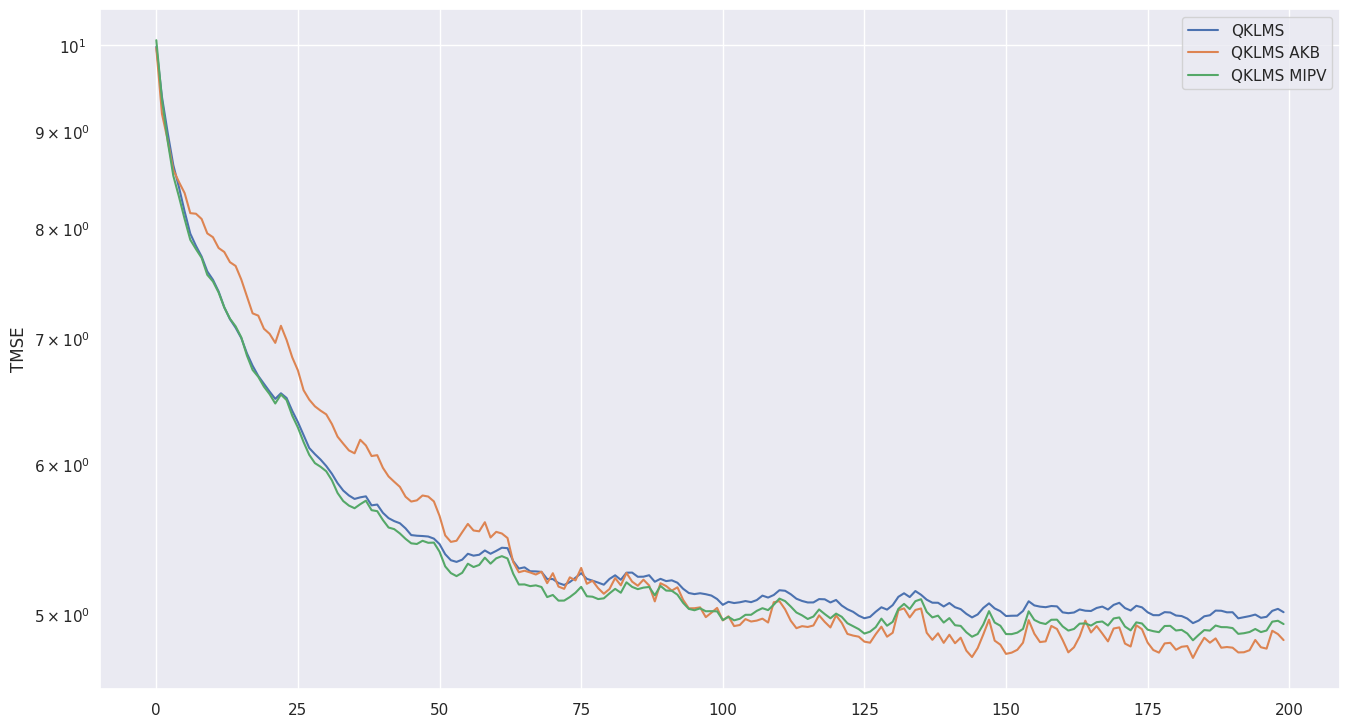

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE)

## Summary

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results])

QKLMS    QKLMS_AKB   QKLMS_MIPV
            train        train        train
MSE      5.644919     5.542624     5.490294
MAE      1.689792     1.675702     1.661579
MAPE  5551.561886  6800.999758  5952.182652

# Sunspot dataset

13-month smoothed monthly total sunspot number dataset from:  

10.1016/j.dsp.2021.103255

## Data preparations

In [ ]:
data = pd.read_csv('/content/SN_ms_tot_V2.0.csv', sep=';')
data.shape

(3274, 7)

In [ ]:
train_start, train_end = 1822, 1946
test_start, test_end = 1947, 1958

In [ ]:
df = data[data['year'].between(train_start,test_end, inclusive='both')]
df.reset_index(drop=True, inplace=True)
X = df.monthly_mean_total.to_numpy()[:1605]
X.shape

(1605,)

In [ ]:
S = z_scorer(X)
system_emb = mc_sampler(S, 1600 , 1, embedding=5)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=1500/1600
train_size = int(1600*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (1500, 5) (1500, 1)
test  (100, 5) (100, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
29  0.5      0.2   0.35  0.015058  ...  0.092566  0.121923  13.176971  0.091845
24  0.5      0.1   0.35  0.008606  ...  0.271470  0.279658  13.558314  0.271390
4   0.1      0.1   0.35  0.010071  ...  0.271520  0.280309  14.152988  0.271411
14  0.1      0.3   0.35  0.010812  ...  0.046605  0.086325  14.309338  0.045864
9   0.1      0.2   0.35  0.010043  ...  0.091884  0.115423  14.508260  0.091561

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
14  0.1      0.3   0.35  0.010812  ...  0.046605  0.086325  14.309338  0.045864
34  0.5      0.3   0.35  0.013341  ...  0.047256  0.097518  14.788962  0.046138
19  0.1      0.6   0.35  0.072448  ...  0.073788  0.227162  52.096353  0.048654
54  0.9      0.3   0.35  0.045085  ...  0.063936  0.159193  29.668778  0.053814
39  0.5      0.6   0.35  0.081079  ...  0.082279  0.240885  56.634687  0.053995

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.3, sigma=0.35)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
qklms_model = filt_trainned


Training complete

Final codebook size:  68
Final kernel bandwidth:  0.35


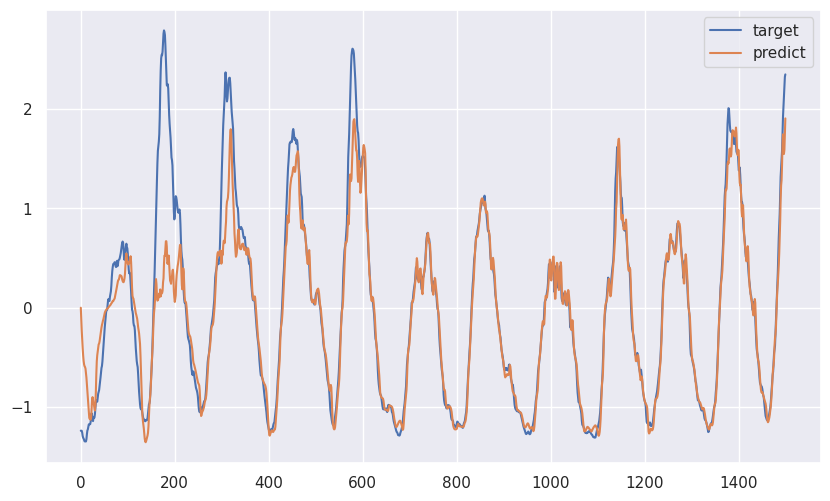

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
           train
MSE     0.137424
MAE     0.174648
MAPE  545.234709

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS', type_='test')
qklms_results_test

QKLMS
           test
MSE    0.010812
MAE    0.073464
MAPE  14.309266

## QKLMS AKB Grid search

In [ ]:
 #tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
338  0.5      0.1        0.10  0.1  ...  0.271614  0.285282  14.590871  0.271450
662  0.9      0.1        0.10  0.2  ...  0.271712  0.286599  14.715612  0.271490
83   0.1      0.2        0.05  0.1  ...  0.092175  0.126914  15.081959  0.091682
384  0.5      0.1        0.35  0.1  ...  0.271668  0.286426  15.127762  0.271472
385  0.5      0.1        0.35  0.1  ...  0.271668  0.286427  15.140776  0.271472

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
276  0.1      0.6        0.15  0.2  ...  0.035431  0.157517  46.061485  0.025184
291  0.1      0.6        0.20  0.1  ...  0.036077  0.158074  45.299239  0.025560
290  0.1      0.6        0.20  0.1  ...  0.036174  0.158181  45.249098  0.025617
289  0.1      0.6        0.20  0.1  ...  0.036361  0.158387  45.152279  0.025726
288  0.1      0.6        0.20  0.1  ...  0.037362  0.159911  44.893305  0.026313

[5 rows x 14 columns]

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.15, mu=0.2, K=1)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
akb_model = filt_trainned


Training complete

Final codebook size:  21
Final kernel bandwidth:  [0.70741569]


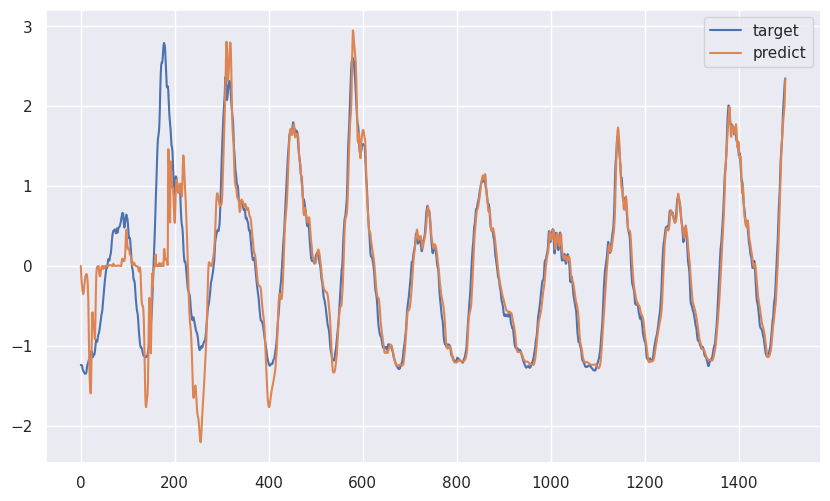

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

[0.70741569]


In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
            train
MSE      0.163104
MAE      0.219383
MAPE  1108.126283

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB')
akb_results_test

QKLMS_AKB
          train
MSE    0.032548
MAE    0.156893
MAPE  46.061483

## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5,10,20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
24  0.5      0.3    0.1   5  ...  0.046689  0.091827  13.318414  0.045899
20  0.5      0.2    0.1   5  ...  0.092674  0.123697  13.380884  0.091890
21  0.5      0.2    0.1  10  ...  0.093164  0.140079  14.283362  0.092095
2   0.1      0.1    0.1  20  ...  0.271479  0.281439  14.368050  0.271394
4   0.1      0.2    0.1   5  ...  0.091952  0.117040  14.672236  0.091590

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
12  0.1      0.6    0.1   5  ...  0.040944  0.166782  45.042594  0.028432
8   0.1      0.3    0.1   5  ...  0.046286  0.089887  16.160012  0.045730
24  0.5      0.3    0.1   5  ...  0.046689  0.091827  13.318414  0.045899
9   0.1      0.3    0.1  10  ...  0.047898  0.117716  25.394271  0.046412
10  0.1      0.3    0.1  20  ...  0.050375  0.137290  31.112263  0.047484

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
mipv_model = filt_trainned


Training complete

Final codebook size:  21
Final kernel bandwidth:  1.1081238119402794


In [ ]:
train_plotter(y,y_pred_train)

1.1081238119402794


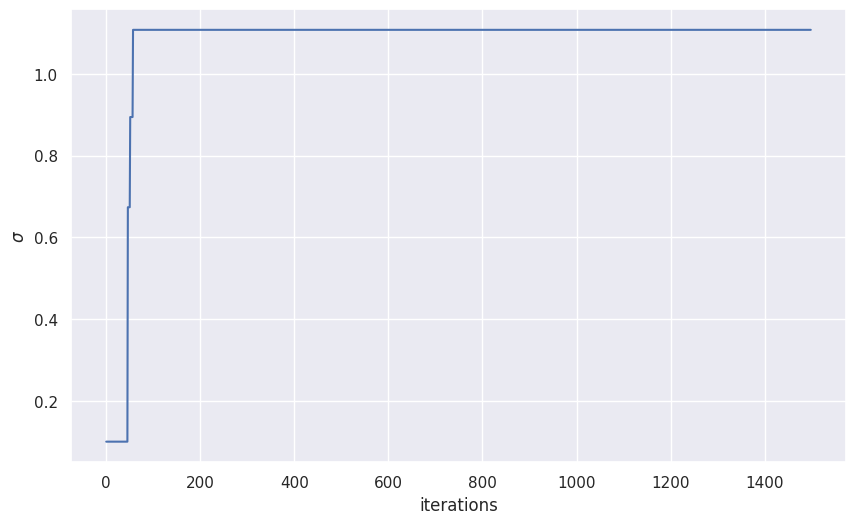

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
           train
MSE     0.106891
MAE     0.179476
MAPE  990.064935

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV')
mipv_results_test

QKLMS_MIPV
          train
MSE    0.038269
MAE    0.165114
MAPE  46.182646

## QKLMS AMK Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma    mu  K       MSE       MAE       MAPE        R2  \
118  0.1      0.2    0.1  0.40  6  0.008698  0.074840  13.106629  0.994405   
193  0.1      0.2    0.4  0.40  6  0.008698  0.074840  13.106629  0.994405   
168  0.1      0.2    0.3  0.40  6  0.008698  0.074840  13.106629  0.994405   
143  0.1      0.2    0.2  0.40  6  0.008698  0.074840  13.106629  0.994405   
253  0.1      0.3    0.3  0.05  6  0.007078  0.065225  13.150100  0.995448   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
118        37  0.026155  0.078800  13.106653  0.025293  
193        37  0.026155  0.078800  13.106653  0.025293  
168        37  0.026155  0.078800  13.106653  0.025293  
143        37  0.026155  0.078800  13.106653  0.025293  
253        39  0.026946  0.070216  13.150126  0.026396

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma   mu  K       MSE       MAE       MAPE        R2  \
368  0.1      0.6    0.3  0.4  6  0.011248  0.088923  18.378268  0.992765   
318  0.1      0.6    0.1  0.4  6  0.011248  0.088923  18.378268  0.992765   
393  0.1      0.6    0.4  0.4  6  0.011248  0.088923  18.378268  0.992765   
343  0.1      0.6    0.2  0.4  6  0.011248  0.088923  18.378268  0.992765   
321  0.1      0.6    0.1  0.6  2  0.017347  0.104257  15.917912  0.988843   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
368        10  0.013076  0.089173  18.378269  0.009838  
318        10  0.013076  0.089173  18.378269  0.009838  
393        10  0.013076  0.089173  18.378269  0.009838  
343        10  0.013076  0.089173  18.378269  0.009838  
321         6  0.017802  0.104334  15.917912  0.011852

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.1, epsilon=0.6, sigma=0.3, mu=0.4, Ka=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  10
Final kernel bandwidth:  0.3


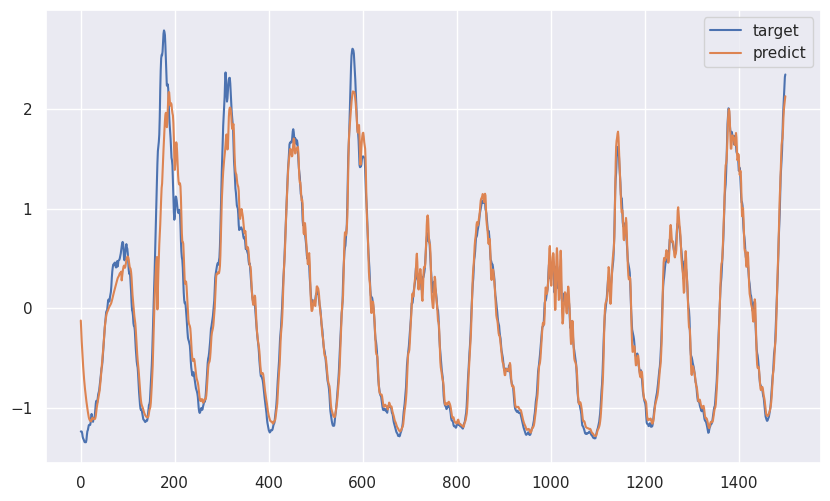

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
           train
MSE     0.041731
MAE     0.114287
MAPE  612.076817

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
           test
MSE    0.011248
MAE    0.088923
MAPE  18.378268

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    df = data[data['year'].between(train_start,test_end, inclusive='both')]
    df.reset_index(drop=True, inplace=True)
    X = df.monthly_mean_total.to_numpy()[:1605]
    S = z_scorer(X)
    system_emb = mc_sampler(S, 1600 , 1, embedding=5)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=1500/1600
    train_size = int(1600*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)

    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.3, 'sigma':0.35}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1500, 5) (50, 1500, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'sunspot_QKLMS_1500_100.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.15, 'mu':0.2, 'K':1}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1500, 5) (50, 1500, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'sunspot_AKB_1500_100.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.5, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1500, 5) (50, 1500, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + 'sunspot_MIPV_1500_100.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.3, 'mu':0.4, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 1500, 5) (50, 1500, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'sunspot_AMK_1500_100.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

### Curves

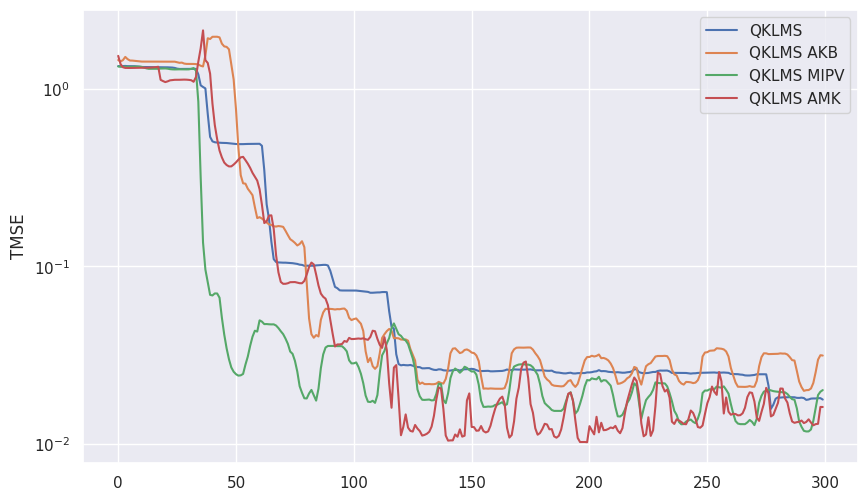

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE)

## Summary

### Scores

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results, amk_results])

QKLMS    QKLMS_AKB  QKLMS_MIPV   QKLMS_AMK
           train        train       train       train
MSE     0.137424     0.163104    0.106891    0.041731
MAE     0.174648     0.219383    0.179476    0.114287
MAPE  545.234709  1108.126283  990.064935  612.076817

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test, amk_results_test])

QKLMS  QKLMS_AKB QKLMS_MIPV  QKLMS_AMK
           test      train      train       test
MSE    0.010812   0.032548   0.038269   0.011248
MAE    0.073464   0.156893   0.165114   0.088923
MAPE  14.309266  46.061483  46.182646  18.378268

### Codebook & sigma changes over time

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model, akb_model, mark_steps=100, tikz_name="Sunspot_CB.tex")

# Chua time-series

Zhao, J., Zhang, H., &#38; Zhang, J. A. (2020). Gaussian kernel adaptive filters with adaptive kernel bandwidth. <i>Signal Processing</i>, <i>166</i>, 107270. https://doi.org/10.1016/j.sigpro.2019.107270

Shen, M., Feng, W., Huang, G., Qi, L., Liu, Y., &#38; Wang, S. (2022). Combined multiple random features least mean square algorithm for online applications. <i>IET Signal Processing</i>, <i>16</i>(4), 391–399. https://doi.org/10.1049/SIL2.12102

## Data preparations

In [ ]:
from KAF.datasets.tools import noisy_chua_generator

embedding=5
samples = 2900
x_at, y_at, z_at = GenerateAttractor(samples=samples+embedding, attractor='chua')
system = z_scorer(x_at)

system_emb = mc_sampler(system, samples , 1, embedding=embedding)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=2800/2900
train_size = int(samples*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)

print("train ", Xtrain.shape, ytrain.shape)
print("test ", Xtest.shape, ytest.shape)

train  (2800, 5) (2800, 1)
test  (100, 5) (100, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (200, 1)
(200, 1) (

eta  epsilon  sigma       MSE       MAE       MAPE        R2  final_CB  \
23  0.5      0.1   0.20  0.002528  0.039373  15.843869  0.997737       147   
22  0.5      0.1   0.15  0.002958  0.042494  16.341772  0.997351       147   
43  0.9      0.1   0.20  0.003668  0.046015  17.171095  0.996716       147   
42  0.9      0.1   0.15  0.003506  0.046099  17.334523  0.996861       147   
44  0.9      0.1   0.35  0.003347  0.045038  18.557426  0.997003       147   

    toff_MSE  toff_MAE  toff_MAPE   toff_R2  
23  0.073543  0.083382  15.844040  0.073535  
22  0.073560  0.084900  16.341937  0.073548  
43  0.073591  0.086716  17.171252  0.073573  
42  0.073584  0.086760  17.334679  0.073567  
44  0.073576  0.086201  18.557572  0.073561

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma        MSE  ...   toff_MSE  toff_MAE  toff_MAPE   toff_R2
54  0.9      0.3   0.35  16.913357  ...  16.913397  3.620364  87.719829  0.940787
34  0.5      0.3   0.35  16.953614  ...  16.953653  3.650833  88.764380  0.943023
49  0.9      0.2   0.35  16.943550  ...  16.943662  3.644039  94.598360  0.943784
39  0.5      0.6   0.35  16.984139  ...  16.984143  3.667915  91.782028  0.944085
59  0.9      0.6   0.35  17.004156  ...  17.004159  3.647425  91.309515  0.945197

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.9, epsilon=0.3, sigma=0.35)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
qklms_model = filt_trainned


Training complete

Final codebook size:  104
Final kernel bandwidth:  0.35


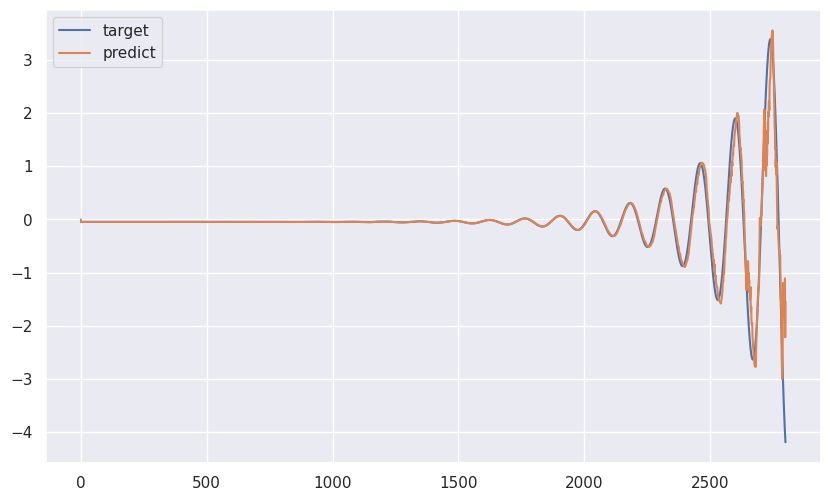

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
            train
MSE      0.047672
MAE      0.064151
MAPE  2943.798902

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS', 'test')
qklms_results_test

QKLMS
           test
MSE   16.171560
MAE    3.550262
MAPE  87.444708

## QKLMS AKB Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...   toff_MSE  toff_MAE  toff_MAPE   toff_R2
405  0.5      0.2        0.05  0.2  ...  11.896827  2.623071  61.604527  0.947679
406  0.5      0.2        0.05  0.2  ...  11.896827  2.623071  61.604527  0.947679
407  0.5      0.2        0.05  0.2  ...  11.896827  2.623071  61.604527  0.947679
404  0.5      0.2        0.05  0.2  ...  11.900603  2.623707  61.755710  0.947978
443  0.5      0.2        0.15  0.4  ...  11.900046  2.633222  62.177589  0.947934

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...   toff_MSE  toff_MAE   toff_MAPE   toff_R2
301  0.1      0.6        0.20  0.6  ...  10.464274  2.502718  117.028064  0.831514
302  0.1      0.6        0.20  0.6  ...  10.464274  2.502718  117.028067  0.831514
303  0.1      0.6        0.20  0.6  ...  10.464274  2.502718  117.028067  0.831514
317  0.1      0.6        0.35  0.6  ...  10.488814  2.504805  114.856477  0.833464
318  0.1      0.6        0.35  0.6  ...  10.488890  2.504783  114.855097  0.833470

[5 rows x 14 columns]

In [ ]:
results.to_csv(savepath + "QKLMS_AKB_chua_4000_firstRun.csv")

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.2, mu=0.6, K=2)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
akb_model = filt_trainned


Training complete

Final codebook size:  34
Final kernel bandwidth:  1.8949271024169867


In [ ]:
train_plotter(y,y_pred_train)

1.8949271024169867


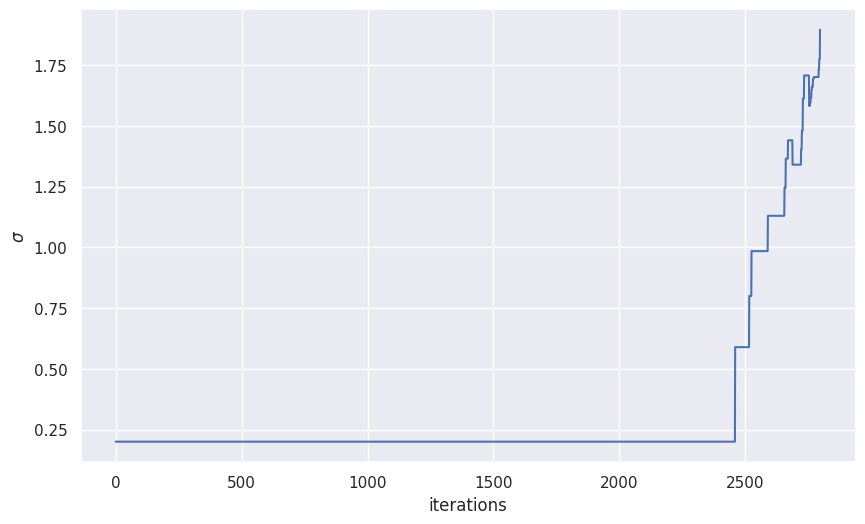

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
             train
MSE       0.108246
MAE       0.134633
MAPE  37395.508157

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB', 'test')
akb_results_test

QKLMS_AKB
            test
MSE    13.055368
MAE     3.052471
MAPE  103.448736

## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5,10,20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...   toff_MSE  toff_MAE  toff_MAPE   toff_R2
18  0.5      0.1    0.1  20  ...  12.052845  2.633224  68.327592  0.964899
25  0.5      0.3    0.1  10  ...  12.188569  2.686449  70.606495  0.969123
19  0.5      0.1    0.1  40  ...  11.886179  2.635520  72.772609  0.951758
21  0.5      0.2    0.1  10  ...  12.149728  2.656304  73.051089  0.967722
24  0.5      0.3    0.1   5  ...  12.426247  2.763538  76.837975  0.987994

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...   toff_MSE  toff_MAE   toff_MAPE   toff_R2
15  0.1      0.6    0.1  40  ...   8.129184  2.376762  106.421864  0.646013
14  0.1      0.6    0.1  20  ...   8.963669  2.438956  110.031410  0.712304
11  0.1      0.3    0.1  40  ...   9.355628  2.426936  102.573434  0.744252
10  0.1      0.3    0.1  20  ...  10.350519  2.490608   96.877221  0.823211
13  0.1      0.6    0.1  10  ...  10.534681  2.553969  107.649544  0.837108

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=40, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
mipv_model = filt_trainned


Training complete

Final codebook size:  34
Final kernel bandwidth:  4.901379907891687


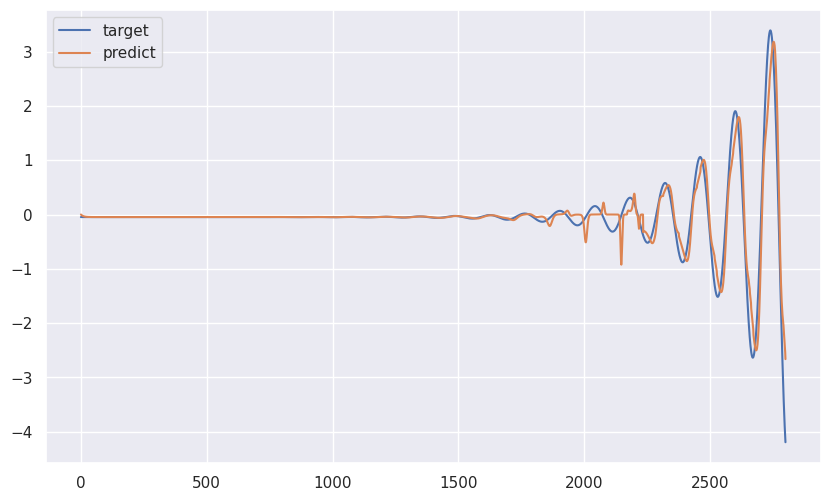

In [ ]:
train_plotter(y,y_pred_train)

4.901379907891687


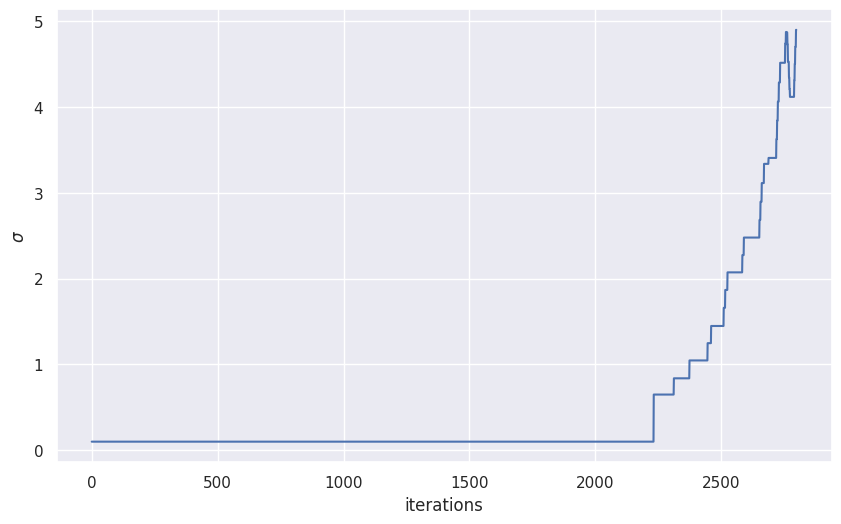

In [ ]:
sigma_plotter(filt_trainned)

In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
             train
MSE       0.052100
MAE       0.102600
MAPE  55376.524883

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS-MIPV', 'test')
mipv_results_test

QKLMS-MIPV
            test
MSE     9.689790
MAE     2.712706
MAPE  122.076275

## QKLMS AMK Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma   mu  K       MSE       MAE       MAPE       R2  \
372  0.1      0.6    0.3  0.6  4  7.194008  2.245732  58.013427  0.56107   
322  0.1      0.6    0.1  0.6  4  7.194008  2.245732  58.013427  0.56107   
397  0.1      0.6    0.4  0.6  4  7.194008  2.245732  58.013427  0.56107   
347  0.1      0.6    0.2  0.6  4  7.194008  2.245732  58.013427  0.56107   
330  0.1      0.6    0.2  0.1  1  8.277374  2.305222  58.902443  0.49497   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
372        10  7.194009  2.245735  58.013427  0.438945  
322        10  7.194009  2.245735  58.013427  0.438945  
397        10  7.194009  2.245735  58.013427  0.438945  
347        10  7.194009  2.245735  58.013427  0.438945  
330        24  8.277378  2.305238  58.902443  0.505103

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma   mu  K       MSE       MAE       MAPE        R2  \
843  0.9      0.1    0.2  0.4  6  2.412401  1.192445  62.052966  0.852811   
818  0.9      0.1    0.1  0.4  6  2.412401  1.192445  62.052966  0.852811   
868  0.9      0.1    0.3  0.4  6  2.412401  1.192445  62.052966  0.852811   
893  0.9      0.1    0.4  0.4  6  2.412401  1.192445  62.052966  0.852811   
113  0.1      0.2    0.1  0.2  6  4.363917  1.855901  97.599345  0.733743   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
843        88  2.412606  1.192859  62.052974  0.150507  
818        88  2.412606  1.192859  62.052974  0.150507  
868        88  2.412606  1.192859  62.052974  0.150507  
893        88  2.412606  1.192859  62.052974  0.150507  
113        41  4.363941  1.855959  97.599346  0.266659

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.9, epsilon=0.1, sigma=0.2, mu=0.4, Ka=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  88
Final kernel bandwidth:  0.2


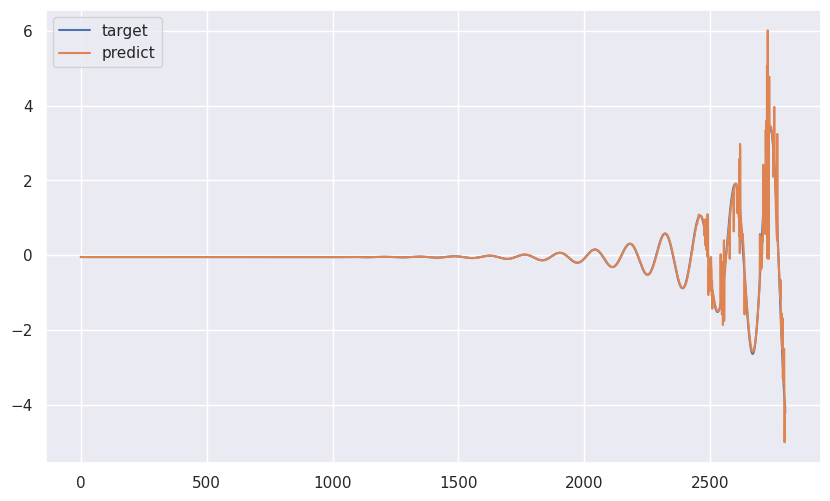

In [ ]:
train_plotter(y,y_pred_train)

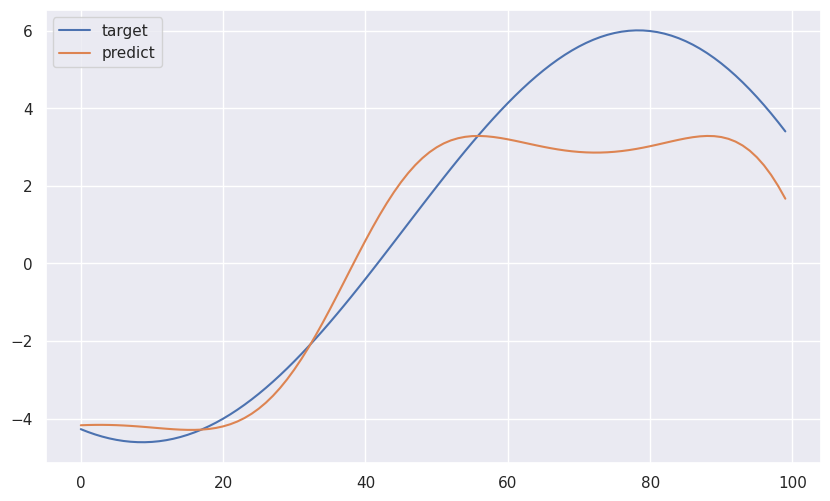

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
            train
MSE      0.036158
MAE      0.035616
MAPE  1527.678721

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
           test
MSE    2.412401
MAE    1.192445
MAPE  62.052966

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    embedding=5
    samples = 2900
    x_at, y_at, z_at = GenerateAttractor(samples=samples+embedding, attractor='lorenz')
    system = z_scorer(x_at)

    system_emb = mc_sampler(system, samples , 1, embedding=embedding)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=2800/2900
    train_size = int(samples*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.9, 'epsilon':0.3, 'sigma':0.35}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2800, 5) (50, 2800, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'chua_QKLMS_2800_100.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.2, 'mu':0.6, 'K':2}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2800, 5) (50, 2800, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'chua_AKB_2800_100.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':40, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2800, 5) (50, 2800, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'chua_MIPV_2800_100.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.9, 'epsilon':0.1, 'sigma':0.2, 'mu':0.4, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2800, 5) (50, 2800, 1)
Test shapes:  (50, 100, 5) (50, 100, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'chua_AMK_2800_100.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

### Curves

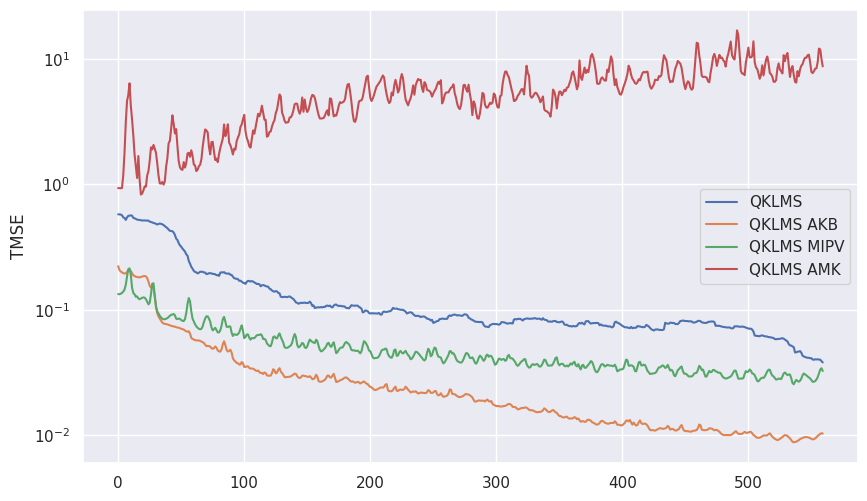

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE)

## Summary

### Scores

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results, amk_results])

QKLMS     QKLMS_AKB    QKLMS_MIPV    QKLMS_AMK
            train         train         train        train
MSE      0.047672      0.108246      0.052100     0.036158
MAE      0.064151      0.134633      0.102600     0.035616
MAPE  2943.798902  37395.508157  55376.524883  1527.678721

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test, amk_results_test])

QKLMS   QKLMS_AKB  QKLMS-MIPV  QKLMS_AMK
           test        test        test       test
MSE   16.171560   13.055368    9.689790   2.412401
MAE    3.550262    3.052471    2.712706   1.192445
MAPE  87.444708  103.448736  122.076275  62.052966

### Codebook & sigma changes over time

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model, amk_model, mark_steps=100, tikz_name="Chua_CB.tex")

NameError: ignored

- Mejores resultados con MIPV  en todas las metricas

# Lorenz time-series

Luo, X., Deng, J., Wang, W., Wang, J. H., &#38; Zhao, W. (2017). A quantized kernel learning algorithm using a minimum kernel risk-sensitive loss criterion and bilateral gradient technique. <i>Entropy</i>, <i>19</i>(7). https://doi.org/10.3390/e19070365

Chen, B., Liang, J., Zheng, N., &#38; Príncipe, J. C. (2016). Kernel least mean square with adaptive kernel size. <i>Neurocomputing</i>, <i>191</i>, 95–106. https://doi.org/10.1016/J.NEUCOM.2016.01.004

Pokharel, R., Seth, S., &#38; Principe, J. C. (2013). Mixture kernel least mean square. <i>Proceedings of the International Joint Conference on Neural Networks</i>. https://doi.org/10.1109/IJCNN.2013.6706867

Huang, W., &#38; Chen, C. (2021). A novel quaternion kernel LMS algorithm with variable kernel width. <i>IEEE Transactions on Circuits and Systems II: Express Briefs</i>, <i>68</i>(7), 2715–2719. https://doi.org/10.1109/TCSII.2021.3056452

## Data preparation

In [ ]:
embedding=5
samples = 4200
x_at, y_at, z_at = GenerateAttractor(samples=samples+embedding, attractor='lorenz')
system = z_scorer(x_at)

system_emb = mc_sampler(system, samples , 1, embedding=embedding)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=4000/4200
train_size = int(samples*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (4000, 5) (4000, 1)
test  (200, 5) (200, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
4   0.1      0.1   0.35  0.003182  ...  0.120792  0.126155  11.356035  0.120800
9   0.1      0.2   0.35  0.003263  ...  0.042874  0.055036  14.478759  0.042898
8   0.1      0.2   0.20  0.015555  ...  0.045492  0.084032  18.056544  0.046006
34  0.5      0.3   0.35  0.010323  ...  0.025897  0.059480  20.510508  0.026293
23  0.5      0.1   0.20  0.004003  ...  0.120816  0.123448  21.377084  0.120829

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['R2'], ascending=False).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
4   0.1      0.1   0.35  0.003182  ...  0.120792  0.126155  11.356035  0.120800
9   0.1      0.2   0.35  0.003263  ...  0.042874  0.055036  14.478759  0.042898
14  0.1      0.3   0.35  0.003861  ...  0.024062  0.042518  27.016052  0.024122
23  0.5      0.1   0.20  0.004003  ...  0.120816  0.123448  21.377084  0.120829
24  0.5      0.1   0.35  0.006214  ...  0.120910  0.125474  45.832893  0.120941

[5 rows x 12 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
29  0.1      0.8    0.5  0.000127  ...  0.005501  0.010072   2.017348  0.010592
28  0.1      0.8    0.5  0.000127  ...  0.005501  0.010072   2.017348  0.010592
84  0.6      0.4    0.5  0.000013  ...  0.015250  0.015512   0.631950  0.015280
83  0.6      0.4    0.5  0.000013  ...  0.015250  0.015512   0.631950  0.015280
58  0.3      0.8    0.5  0.000249  ...  0.005506  0.012167   2.464005  0.018595

[5 rows x 12 columns]

## QKLMS Filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.8, sigma=0.5)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  21
Final kernel bandwidth:  0.5


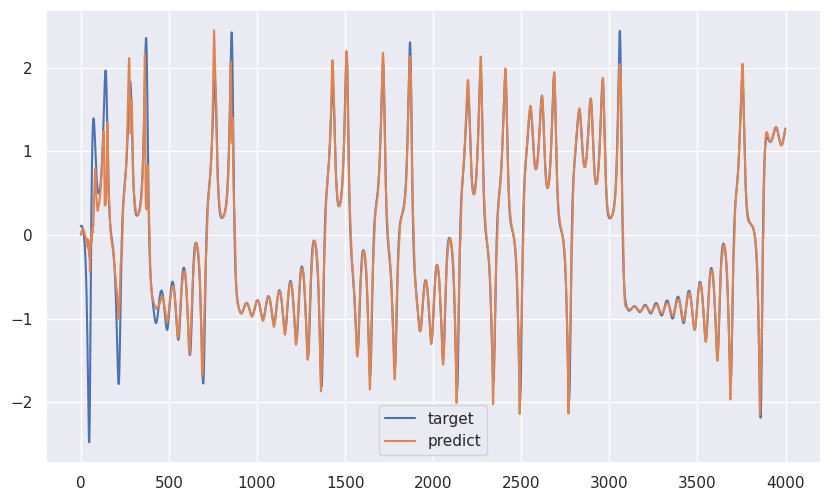

In [ ]:
train_plotter(y,y_pred_train)

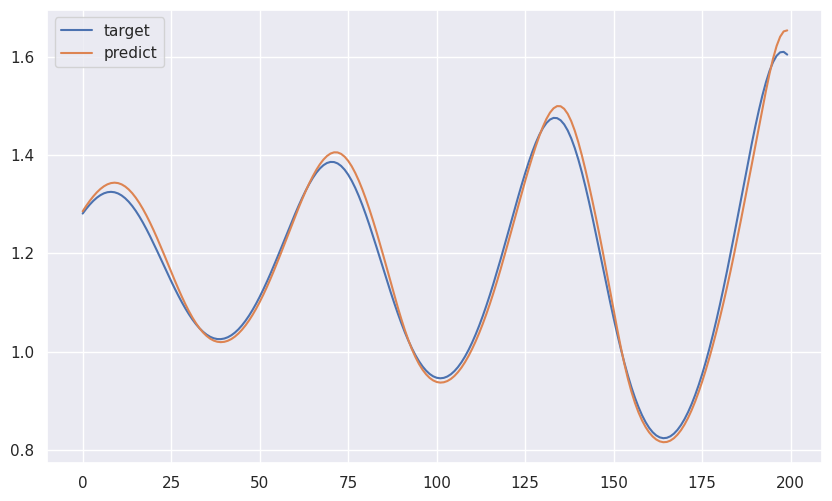

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
            train
MSE      0.050648
MAE      0.083639
MAPE  1400.281945

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS', 'test')
qklms_results_test

QKLMS
          test
MSE   0.000403
MAE   0.016843
MAPE  2.779772

In [ ]:
qklms_model = filt_trainned

## QKLMS AKB Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
549  0.5      0.3        0.35  0.2  ...  0.023769  0.028404   5.532506  0.023773
548  0.5      0.3        0.35  0.2  ...  0.023769  0.028407   5.704638  0.023773
550  0.5      0.3        0.35  0.2  ...  0.023770  0.028468   6.829175  0.023774
448  0.5      0.2        0.20  0.1  ...  0.042756  0.047938   8.171745  0.042757
449  0.5      0.2        0.20  0.1  ...  0.042756  0.048008   8.494221  0.042757

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
279  0.1      0.6        0.15  0.2  ...  0.008653  0.033218  83.714134  0.008682
291  0.1      0.6        0.20  0.1  ...  0.008673  0.034604  82.159816  0.008707
290  0.1      0.6        0.20  0.1  ...  0.008674  0.034045  77.206385  0.008708
289  0.1      0.6        0.20  0.1  ...  0.008675  0.033977  76.761397  0.008708
288  0.1      0.6        0.20  0.1  ...  0.008675  0.033837  75.811101  0.008709

[5 rows x 14 columns]

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.15, mu=0.2, K=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  35
Final kernel bandwidth:  0.2353562350639084


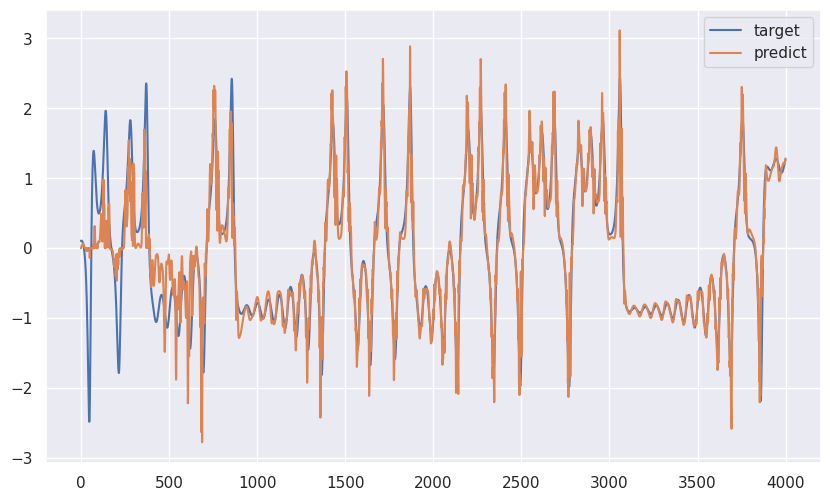

In [ ]:
train_plotter(y,y_pred_train)

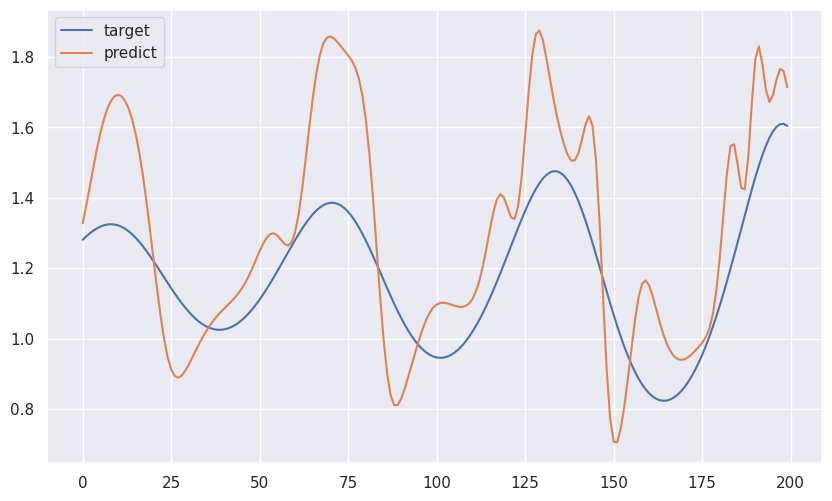

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

0.2353562350639084


In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
            train
MSE      0.160725
MAE      0.229211
MAPE  2014.685652

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB', 'test')
akb_results_test

QKLMS_AKB
           test
MSE    0.049775
MAE    0.186336
MAPE  31.201815

In [ ]:
akb_model = filt_trainned

## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5, 10, 20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
17  0.5      0.1    0.1  10  ...  0.120803  0.123507  10.614378  0.120814
1   0.1      0.1    0.1  10  ...  0.120761  0.123989  14.789022  0.120763
4   0.1      0.2    0.1   5  ...  0.042860  0.054549  15.105424  0.042881
21  0.5      0.2    0.1  10  ...  0.042757  0.048113  17.764766  0.042758
0   0.1      0.1    0.1   5  ...  0.121214  0.136431  19.308793  0.121304

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
12  0.1      0.6    0.1   5  ...  0.008802  0.030310   66.383065  0.008859
28  0.5      0.6    0.1   5  ...  0.009466  0.049420  154.560082  0.009643
13  0.1      0.6    0.1  10  ...  0.011737  0.059522   72.953486  0.012267
14  0.1      0.6    0.1  20  ...  0.015077  0.075037   81.058214  0.016045
15  0.1      0.6    0.1  40  ...  0.019763  0.087305  110.401685  0.021270

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)


Training complete

Final codebook size:  35
Final kernel bandwidth:  1.1829604751787477


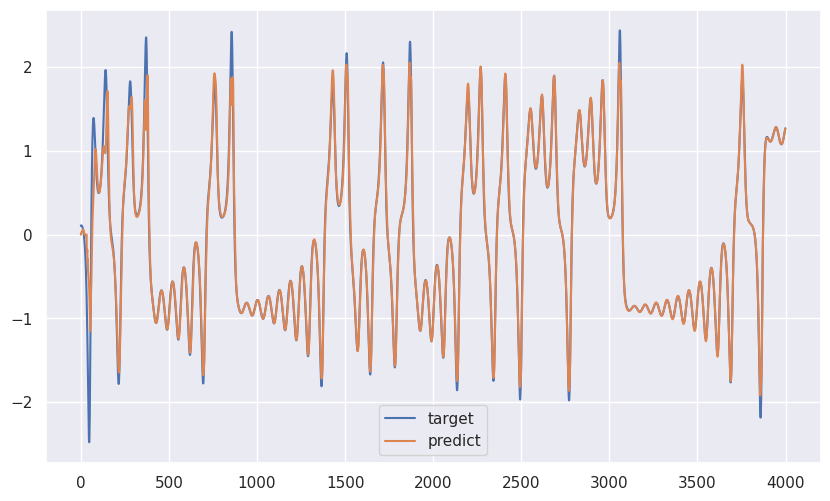

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
sigma_plotter(filt_trainned)

1.1829604751787477


In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
            train
MSE      0.024442
MAE      0.056924
MAPE  1371.685449

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', 'test')
mipv_results_test

QKLMS_MIPV
           test
MSE    0.000248
MAE    0.012877
MAPE   2.368064

In [ ]:
mipv_model = filt_trainned

## QKLMS AMK Grid Search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma    mu  K       MSE       MAE      MAPE        R2  \
201  0.1      0.3    0.1  0.05  2  0.000079  0.007128  1.311298  0.997897   
276  0.1      0.3    0.4  0.05  2  0.000079  0.007128  1.311298  0.997897   
226  0.1      0.3    0.2  0.05  2  0.000079  0.007128  1.311298  0.997897   
251  0.1      0.3    0.3  0.05  2  0.000079  0.007128  1.311298  0.997897   
47   0.1      0.1    0.2  0.60  4  0.000101  0.007166  1.406578  0.997303   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
201        25  0.006250   0.00948   1.311313  0.006594  
276        25  0.006250   0.00948   1.311313  0.006594  
226        25  0.006250   0.00948   1.311313  0.006594  
251        25  0.006250   0.00948   1.311313  0.006594  
47         32  0.008001   0.01074   1.406601  0.008442

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma    mu  K       MSE       MAE      MAPE        R2  \
325  0.1      0.6    0.2  0.05  1  0.000180  0.009348  1.704693  0.995198   
350  0.1      0.6    0.3  0.05  1  0.000180  0.009348  1.704693  0.995198   
300  0.1      0.6    0.1  0.05  1  0.000180  0.009348  1.704693  0.995198   
375  0.1      0.6    0.4  0.05  1  0.000180  0.009348  1.704693  0.995198   
226  0.1      0.3    0.2  0.05  2  0.000079  0.007128  1.311298  0.997897   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
325        17  0.004254  0.010269   1.704698  0.006413  
350        17  0.004254  0.010269   1.704698  0.006413  
300        17  0.004254  0.010269   1.704698  0.006413  
375        17  0.004254  0.010269   1.704698  0.006413  
226        25  0.006250  0.009480   1.311313  0.006594

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.1, epsilon=0.6, sigma=0.2, mu=0.05, Ka=1)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  17
Final kernel bandwidth:  0.2


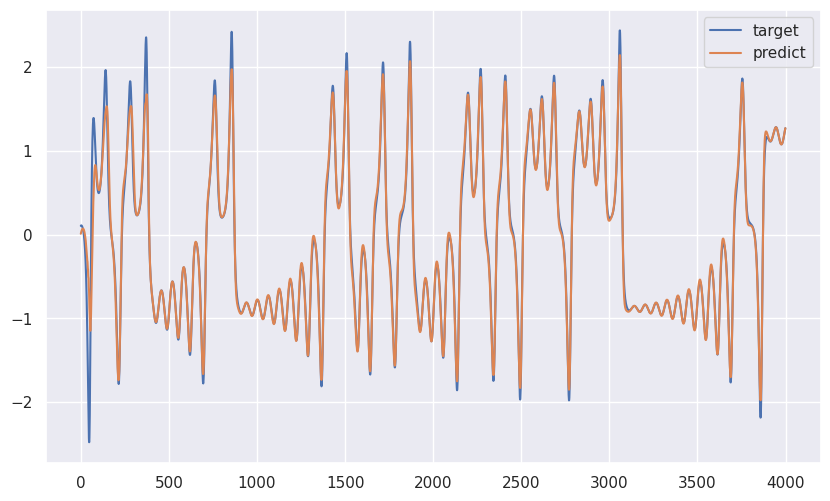

In [ ]:
train_plotter(y,y_pred_train)

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
            train
MSE      0.020276
MAE      0.056660
MAPE  1295.670120

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
          test
MSE   0.000180
MAE   0.009348
MAPE  1.704693

## TMSE calculation

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    embedding=5
    samples = 4200
    x_at, y_at, z_at = GenerateAttractor(samples=samples+embedding, attractor='lorenz')
    system = z_scorer(x_at)

    system_emb = mc_sampler(system, samples , 1, embedding=embedding)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=4000/4200
    train_size = int(samples*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.8, 'sigma':0.5}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'lorenz_QKLMS_4000_200.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.15, 'mu':0.2, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'lorenz_AKB_4000_200.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'lorenz_MIPV_4000_200.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.2, 'mu':0.05, 'K':1}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 4000, 5) (50, 4000, 1)
Test shapes:  (50, 200, 5) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(savepath_drive + 'lorenz_AMK_2000_200.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

## TMSE Curves

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE)

## Summary

### Scores

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results,amk_results])

QKLMS    QKLMS_AKB   QKLMS_MIPV    QKLMS_AMK
            train        train        train        train
MSE      0.050648     0.160725     0.024442     0.020276
MAE      0.083639     0.229211     0.056924     0.056660
MAPE  1400.281945  2014.685652  1371.685449  1295.670120

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test, amk_results_test])

QKLMS  QKLMS_AKB QKLMS_MIPV QKLMS_AMK
          test       test       test      test
MSE   0.000403   0.049775   0.000248  0.000180
MAE   0.016843   0.186336   0.012877  0.009348
MAPE  2.779772  31.201815   2.368064  1.704693

### Codebook & sigma changes over time

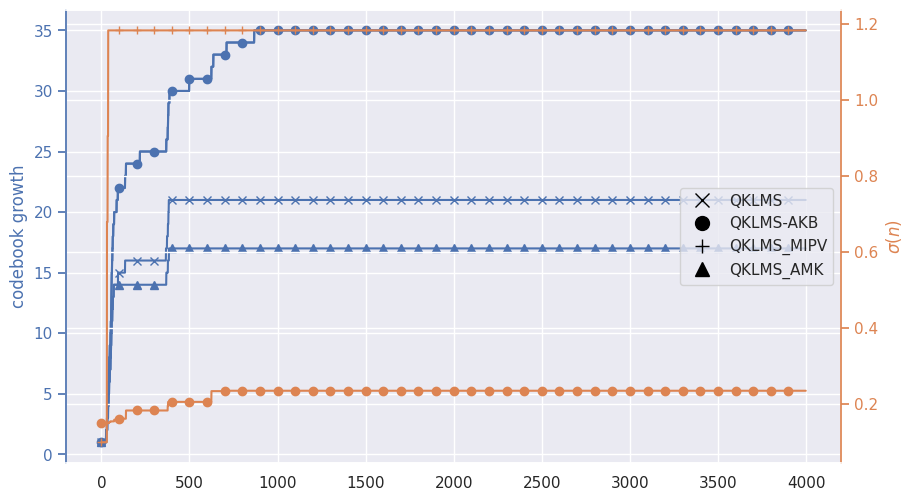

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model, amk_model, mark_steps=100, tikz_name= "lorenz_CB.tex")

- Para el set de test se nota una evidente mejora de los resultados de QKLMS.
- AKB tiene los peores resultados, el ajuste de MIPV en los datos de test se traduce en una mejora del resultado.

![KCC.PNG](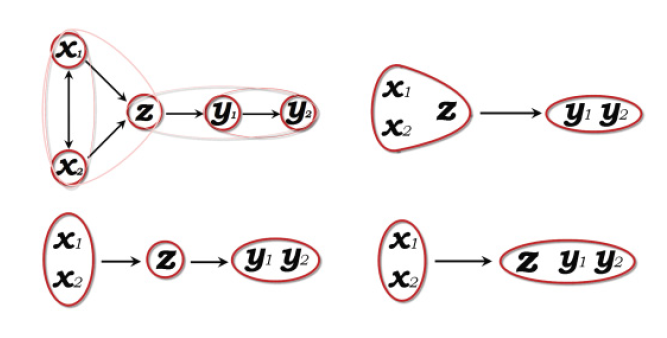![Captura.PNG](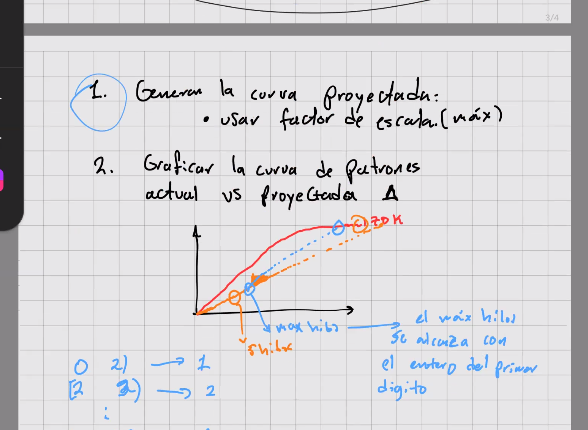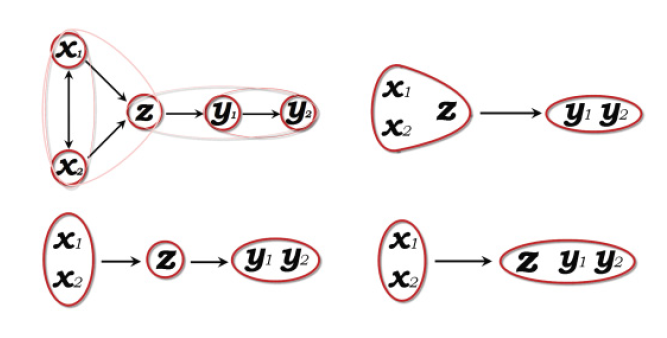))# Nonlinear system - 4.2

Liu, X., Song, C., &#38; Pang, Z. (2022). Kernel recursive maximum correntropy with variable center. <i>Signal Processing</i>, <i>191</i>, 108364. https://doi.org/10.1016/j.sigpro.2021.108364

Zhao, J., Zhang, H., &#38; Zhang, J. A. (2020). Gaussian kernel adaptive filters with adaptive kernel bandwidth. <i>Signal Processing</i>, <i>166</i>, 107270. https://doi.org/10.1016/j.sigpro.2019.107270

Xu, Y., Yang, Z., Liu, Y., &#38; Jiang, S. (2020). Accelerate Convergence of Polarized Random Fourier Feature-Based Kernel Adaptive Filtering with Variable Forgetting Factor and Step Size. <i>IEEE Access</i>, <i>8</i>, 126887–126895. https://doi.org/10.1109/ACCESS.2020.2975536


## Data preparations

In [ ]:
samples = 2200
embedding=2

system = GenerateSystem(samples=samples+embedding, systemType='4.2_AKB')
system = z_scorer(system)

system_emb = mc_sampler(system, samples , 1, embedding=embedding)
X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

train_portion=2000/2200
train_size = int(samples*train_portion)
Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
print("train ", Xtrain.shape,ytrain.shape)
print("test ", Xtest.shape,ytest.shape)

train  (2000, 2) (2000, 1)
test  (200, 2) (200, 1)


In [ ]:
X = Xtrain
y = ytrain

## QKLMS Grid search

In [ ]:
#tunning
filt = KAF.QKLMS()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.05, 0.1, 0.15, 0.2, 0.35]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

eta  epsilon  sigma       MSE       MAE       MAPE        R2  final_CB  \
23  0.5      0.1   0.20  0.002528  0.039373  15.843869  0.997737       147   
22  0.5      0.1   0.15  0.002958  0.042494  16.341772  0.997351       147   
43  0.9      0.1   0.20  0.003668  0.046015  17.171095  0.996716       147   
42  0.9      0.1   0.15  0.003506  0.046099  17.334523  0.996861       147   
44  0.9      0.1   0.35  0.003347  0.045038  18.557426  0.997003       147   

    toff_MSE  toff_MAE  toff_MAPE   toff_R2  
23  0.073543  0.083382  15.844040  0.073535  
22  0.073560  0.084900  16.341937  0.073548  
43  0.073591  0.086716  17.171252  0.073573  
42  0.073584  0.086760  17.334679  0.073567  
44  0.073576  0.086201  18.557572  0.073561

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma       MSE  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
14  0.1      0.3   0.35  0.004323  ...  0.017057  0.052969  19.224829  0.016945
34  0.5      0.3   0.35  0.004796  ...  0.017183  0.053321  18.223361  0.017046
54  0.9      0.3   0.35  0.005405  ...  0.017363  0.056917  18.632247  0.017191
19  0.1      0.6   0.35  0.019204  ...  0.019977  0.099192  30.105112  0.017998
39  0.5      0.6   0.35  0.023007  ...  0.023656  0.109644  32.078628  0.021254

[5 rows x 12 columns]

## QKLMS filtering

In [ ]:
filt = KAF.QKLMS(eta=0.1, epsilon=0.3, sigma=0.35)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
qklms_model = filt_trainned


Training complete

Final codebook size:  34
Final kernel bandwidth:  0.35


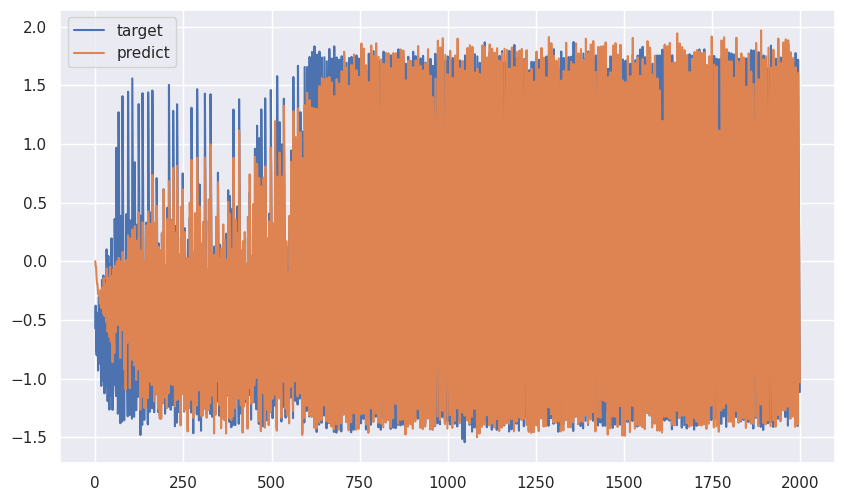

In [ ]:
train_plotter(y,y_pred_train)

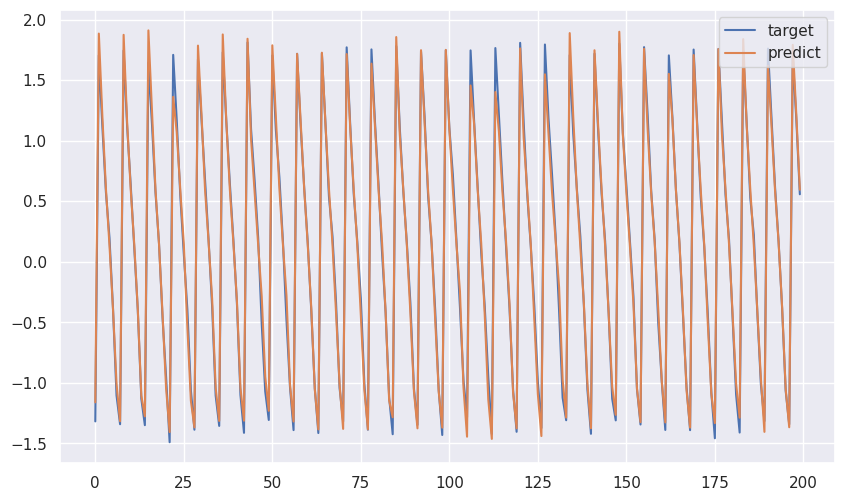

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
qklms_results = scorer(y,y_pred_train,'QKLMS')
qklms_results

QKLMS
           train
MSE     0.030937
MAE     0.107151
MAPE  514.802871

In [ ]:
qklms_results_test = scorer(ytest,y_pred_test,'QKLMS', 'test')
qklms_results_test

QKLMS
           test
MSE    0.007911
MAE    0.064820
MAPE  21.449270

## QKLMS AKB Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_AKB()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma_init': [0.05, 0.1, 0.15, 0.2, 0.35], 'mu':[0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/960 [00:00<?, ?it/s]

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
346  0.5      0.1        0.10  0.4  ...  0.073582  0.087190  16.721311  0.073565
379  0.5      0.1        0.20  0.4  ...  0.073581  0.087176  16.731260  0.073565
374  0.5      0.1        0.20  0.2  ...  0.073583  0.087264  16.748767  0.073566
358  0.5      0.1        0.15  0.2  ...  0.073582  0.087224  16.750818  0.073565
368  0.5      0.1        0.20  0.1  ...  0.073582  0.087257  16.751348  0.073566

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma_init   mu  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
312  0.1      0.6        0.35  0.4  ...  0.011633  0.074202  24.785287  0.010673
316  0.1      0.6        0.35  0.6  ...  0.012598  0.074475  22.759668  0.011513
308  0.1      0.6        0.35  0.2  ...  0.012690  0.079488  26.539732  0.011593
304  0.1      0.6        0.35  0.1  ...  0.014562  0.085256  27.679065  0.013229
317  0.1      0.6        0.35  0.6  ...  0.016399  0.090048  28.545811  0.014843

[5 rows x 14 columns]

In [ ]:
results.to_csv(savepath + "QKLMS_AKB_chua_2000_firstRun.csv")

## QKLMS AKB filtering

In [ ]:
filt = KAF.QKLMS_AKB(eta=0.1, epsilon=0.6, sigma_init=0.35, mu=0.4, K=1)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
akb_model = filt_trainned


Training complete

Final codebook size:  10
Final kernel bandwidth:  [0.55895642]


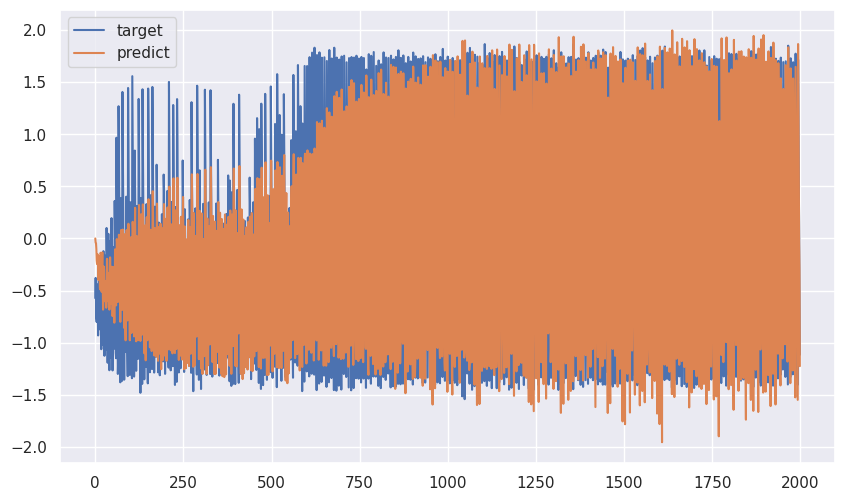

In [ ]:
train_plotter(y,y_pred_train)

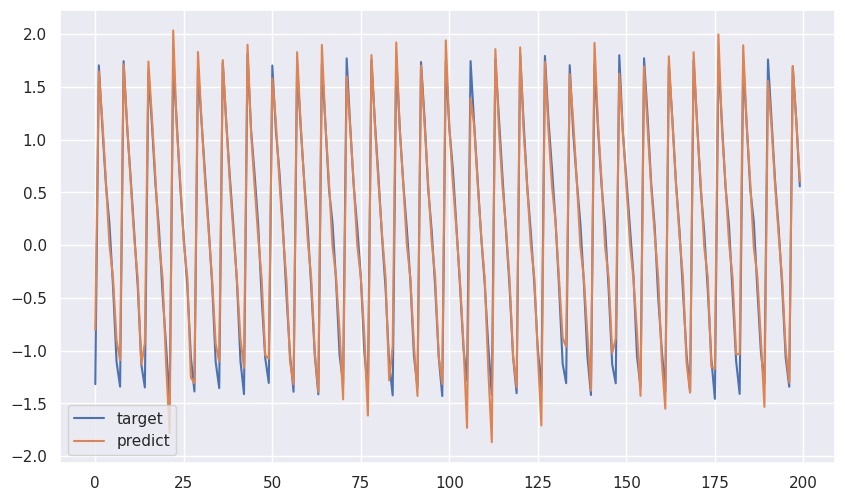

In [ ]:
train_plotter(ytest,y_pred_test)

[0.55895642]


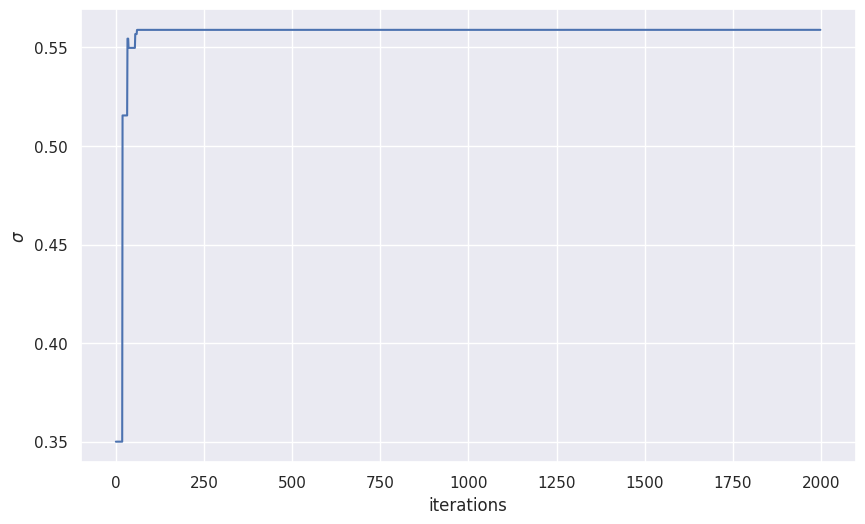

In [ ]:
sigma_plotter(filt_trainned, sigma_record=True)

In [ ]:
sigma_vs_codebook(filt_trainned, True)

TypeError: ignored

In [ ]:
akb_results = scorer(y,y_pred_train,'QKLMS_AKB')
akb_results

QKLMS_AKB
           train
MSE     0.069373
MAE     0.167320
MAPE  911.921567

In [ ]:
akb_results_test = scorer(ytest,y_pred_test,'QKLMS_AKB', 'test')
akb_results_test

QKLMS_AKB
           test
MSE    0.021809
MAE    0.108801
MAPE  37.263718


## QKLMS MIPV Grid search

In [ ]:
#tunning
filt = KAF.QKLMS_varIP_FC()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1], 'FC':[5, 10, 20, 40], 'bounds':[[1e-5,1e2]]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/48 [00:00<?, ?it/s]

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE  toff_MAPE   toff_R2
17  0.5      0.1    0.1  10  ...  0.073583  0.087269  16.753044  0.073566
24  0.5      0.3    0.1   5  ...  0.017255  0.053580  18.108130  0.017104
18  0.5      0.1    0.1  20  ...  0.073626  0.090056  18.247727  0.073600
16  0.5      0.1    0.1   5  ...  0.073710  0.092587  18.482444  0.073667
40  0.9      0.3    0.1   5  ...  0.017558  0.058465  18.803103  0.017347

[5 rows x 14 columns]

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma  FC  ...  toff_MSE  toff_MAE   toff_MAPE   toff_R2
4  0.1      0.6    0.1   5  ...  0.022872  0.125340  182.840098  0.019674
0  0.1      0.3    0.1   5  ...  0.024208  0.079428  121.458958  0.023631
1  0.1      0.3    0.1  10  ...  0.026514  0.099141  126.674988  0.025372
8  0.1      0.8    0.1   5  ...  0.032887  0.158275  425.863006  0.028123
2  0.1      0.3    0.1  20  ...  0.036561  0.153130  525.408439  0.033256

[5 rows x 14 columns]

## QKLMS MIPV filtering

In [ ]:
filt = KAF.QKLMS_varIP_FC(eta=0.1, epsilon=0.6, sigma=0.1, FC=5, bounds=[1e-5,1e2])
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
mipv_model = filt_trainned


Training complete

Final codebook size:  10
Final kernel bandwidth:  0.6638648041133438


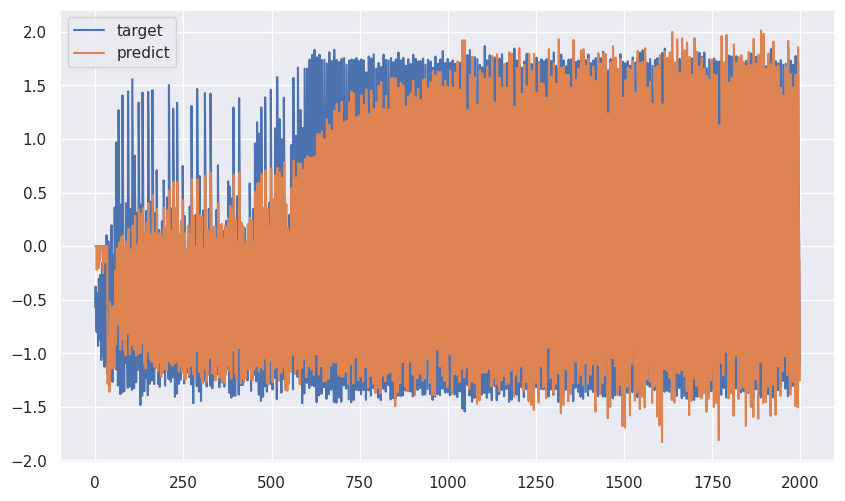

In [ ]:
train_plotter(y,y_pred_train)

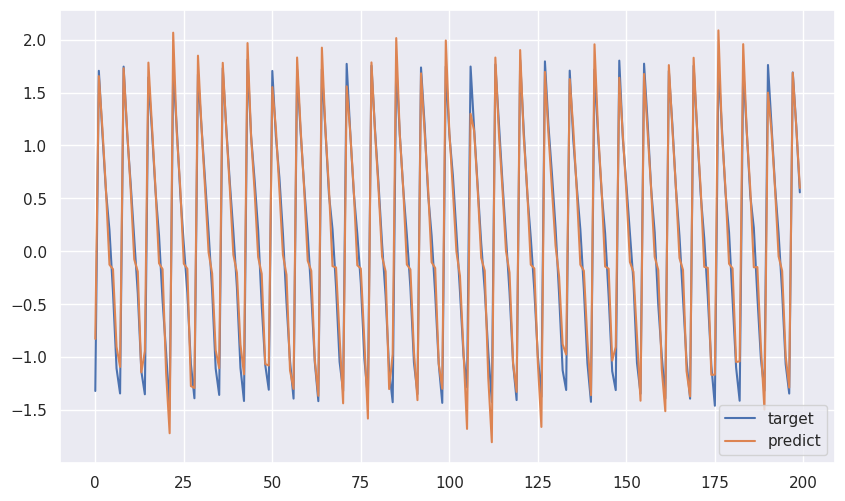

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
sigma_plotter(filt_trainned)

0.6638648041133438


In [ ]:
mipv_results = scorer(y,y_pred_train,'QKLMS_MIPV')
mipv_results

QKLMS_MIPV
            train
MSE      0.086187
MAE      0.198181
MAPE  1281.250464

In [ ]:
mipv_results_test = scorer(ytest,y_pred_test,'QKLMS_MIPV', 'test')
mipv_results_test

QKLMS_MIPV
           test
MSE    0.034486
MAE    0.147899
MAPE  72.373772

## QKLMS AMK Grid Search

In [ ]:
#tunning
filt = KAF.QKLMS_AMK()
params = {'eta':[0.1, 0.5, 0.9], 'epsilon': [0.1, 0.2, 0.3, 0.6], 'sigma': [0.1, 0.2, 0.3, 0.4], 'mu':[0.05, 0.1, 0.2, 0.4, 0.6], 'K':[1,2,4,6,8]}
search_results = best_params_finder_split(filt, Xtrain, ytrain, Xtest, ytest, params)
results = pd.DataFrame(data=search_results)
results.sort_values(by=['MAPE']).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1200 [00:00<?, ?it/s]

eta  epsilon  sigma   mu  K       MSE       MAE       MAPE        R2  \
281  0.1      0.3    0.4  0.1  2  0.004879  0.053286  20.804295  0.995658   
206  0.1      0.3    0.1  0.1  2  0.004879  0.053286  20.804295  0.995658   
231  0.1      0.3    0.2  0.1  2  0.004879  0.053286  20.804295  0.995658   
256  0.1      0.3    0.3  0.1  2  0.004879  0.053286  20.804295  0.995658   
133  0.1      0.2    0.2  0.1  6  0.006942  0.062910  21.594981  0.993821   

     final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
281       177  0.088634  0.103304  20.804484  0.088606  
206       177  0.088634  0.103304  20.804484  0.088606  
231       177  0.088634  0.103304  20.804484  0.088606  
256       177  0.088634  0.103304  20.804484  0.088606  
133       118  0.059407  0.086247  21.595061  0.059323

In [ ]:
results.sort_values(by=['toff_R2']).head()

eta  epsilon  sigma   mu  K       MSE       MAE       MAPE        R2  \
389   0.1      0.6    0.4  0.2  8  0.012482  0.081210  25.788274  0.988889   
314   0.1      0.6    0.1  0.2  8  0.012482  0.081210  25.788274  0.988889   
364   0.1      0.6    0.3  0.2  8  0.012482  0.081210  25.788274  0.988889   
339   0.1      0.6    0.2  0.2  8  0.012482  0.081210  25.788274  0.988889   
1191  0.9      0.6    0.4  0.4  2  0.013995  0.086071  25.107986  0.987543   

      final_CB  toff_MSE  toff_MAE  toff_MAPE   toff_R2  
389         15  0.014562  0.081556  25.788275  0.013405  
314         15  0.014562  0.081556  25.788275  0.013405  
364         15  0.014562  0.081556  25.788275  0.013405  
339         15  0.014562  0.081556  25.788275  0.013405  
1191        10  0.014861  0.086216  25.107986  0.013423

## QKLMS AMK filtering

In [ ]:
filt = KAF.QKLMS_AMK(eta=0.5, epsilon=0.6, sigma=0.3, mu=0.1, Ka=6)
filt_trainned, y_pred_train = filter_evaluation(filt, X, y)
y_pred_test = filt_trainned.predict(Xtest)
amk_model = filt_trainned


Training complete

Final codebook size:  15
Final kernel bandwidth:  0.3


In [ ]:
train_plotter(y,y_pred_train)

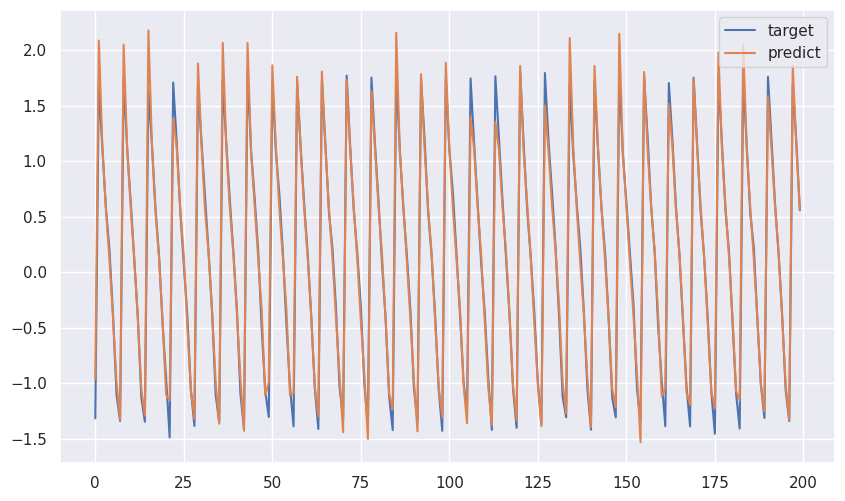

In [ ]:
train_plotter(ytest,y_pred_test)

In [ ]:
amk_results = scorer(y,y_pred_train,'QKLMS_AMK')
amk_results

QKLMS_AMK
           train
MSE     0.039079
MAE     0.127149
MAPE  835.345461

In [ ]:
amk_results_test = scorer(ytest,y_pred_test,'QKLMS_AMK', 'test')
amk_results_test

QKLMS_AMK
           test
MSE    0.017277
MAE    0.088325
MAPE  25.127461

## TMSE

In [ ]:
def dataset(mc_runs):
  Xtrain_array = []
  ytrain_array = []
  Xtest_array = []
  ytest_array = []

  for _ in range(mc_runs):
    samples = 2200
    embedding=2
    system = GenerateSystem(samples=samples+embedding, systemType='4.2_AKB')
    system = z_scorer(system)

    system_emb = mc_sampler(system, samples , 1, embedding=embedding)
    X,y = system_emb[0,:,:-1],system_emb[0,:,-1]

    train_portion=2000/2200
    train_size = int(samples*train_portion)
    Xtrain,ytrain = system_emb[0,:train_size,:-1],system_emb[0,:train_size,-1].reshape(-1,1)
    Xtest,ytest = system_emb[0,train_size:,:-1],system_emb[0,train_size:,-1].reshape(-1,1)
    Xtrain_array.append(Xtrain)
    ytrain_array.append(ytrain)
    Xtest_array.append(Xtest)
    ytest_array.append(ytest)
  return np.array(Xtrain_array),np.array(ytrain_array),np.array(Xtest_array),np.array(ytest_array)

In [ ]:
# Data for TMSE calculation - 50 different generated sets
Xtr, ytr, Xts, yts = dataset(50)

In [ ]:
#testing MSE for QKLMS
model = KAF.QKLMS()
params = {'eta':0.1, 'epsilon':0.3, 'sigma':0.35}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2000, 2) (50, 2000, 1)
Test shapes:  (50, 200, 2) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + '4.2_QKLMS_2000_200.csv')

In [ ]:
QKLMS_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AKB
model = KAF.QKLMS_AKB()
params = {'eta':0.1, 'epsilon':0.6, 'sigma_init':0.35, 'mu':0.4, 'K':1}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2000, 2) (50, 2000, 1)
Test shapes:  (50, 200, 2) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + '4.2_AKB_2000_200.csv')

In [ ]:
AKB_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS MIPV
model = KAF.QKLMS_varIP_FC()
params = {'eta':0.1, 'epsilon':0.6, 'sigma':0.1, 'FC':5, 'bounds':[1e-5,1e2]}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2000, 2) (50, 2000, 1)
Test shapes:  (50, 200, 2) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + '4.2_MIPV_2000_200.csv')

In [ ]:
MIPV_TMSE = results['TMSE_mean']

In [ ]:
#testing MSE for QKLMS AMK
model = KAF.QKLMS_AMK()
params = {'eta':0.5, 'epsilon':0.6, 'sigma':0.3, 'mu':0.1, 'K':6}
results = testingMSE(model, Xtr, ytr, Xts, yts, params, tmse_step=5)

---------------------------------------------
Train shapes:  (50, 2000, 2) (50, 2000, 1)
Test shapes:  (50, 200, 2) (50, 200, 1)
Total runs:  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [ ]:
results.to_csv(tmse_folder + '4.2_AMK_2000_200.csv')

In [ ]:
AMK_TMSE = results['TMSE_mean']

### Curves

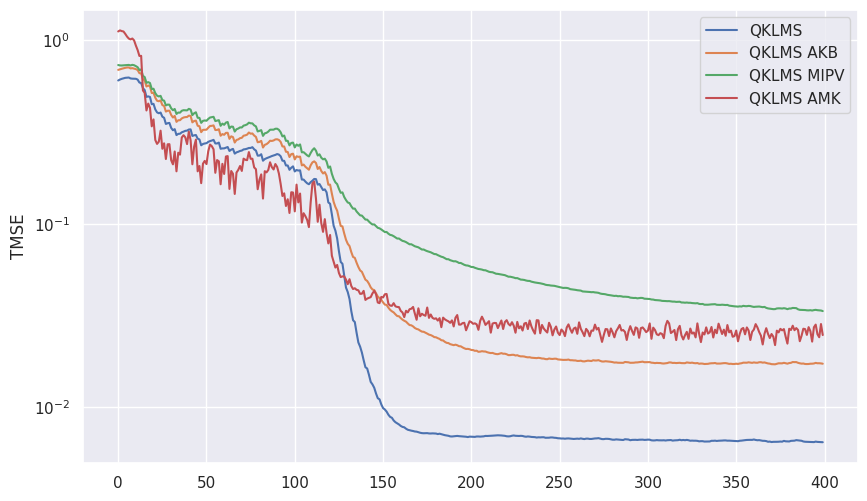

In [ ]:
TMSE_plot(QKLMS_TMSE, AKB_TMSE, MIPV_TMSE, AMK_TMSE)

## Summary

### Scores

In [ ]:
scorer_summary([qklms_results,akb_results,mipv_results,amk_results])

QKLMS   QKLMS_AKB   QKLMS_MIPV   QKLMS_AMK
           train       train        train       train
MSE     0.030937    0.069373     0.086187    0.039079
MAE     0.107151    0.167320     0.198181    0.127149
MAPE  514.802871  911.921567  1281.250464  835.345461

In [ ]:
scorer_summary([qklms_results_test,akb_results_test,mipv_results_test,amk_results_test])

QKLMS  QKLMS_AKB QKLMS_MIPV  QKLMS_AMK
           test       test       test       test
MSE    0.007911   0.021809   0.034486   0.017277
MAE    0.064820   0.108801   0.147899   0.088325
MAPE  21.449270  37.263718  72.373772  25.127461

### Codebook & sigma changes over time

In [ ]:
sigma_vs_codebook(qklms_model, akb_model, mipv_model, amk_model, mark_steps=100, tikz_name="4.2_CB.tex")

# Random Vector Model

Wu G, Duan X, Liao W, Gao Q, Chen H. Kernel canonical-correlation Granger causality for multiple time series. Phys Rev E Stat Nonlin Soft Matter Phys. 2011 Apr;83(4 Pt 1):041921. doi: 10.1103/PhysRevE.83.041921. Epub 2011 Apr 25. PMID: 21599214.

PMID: 21599214 DOI: https://doi.org/10.1103/physreve.83.041921

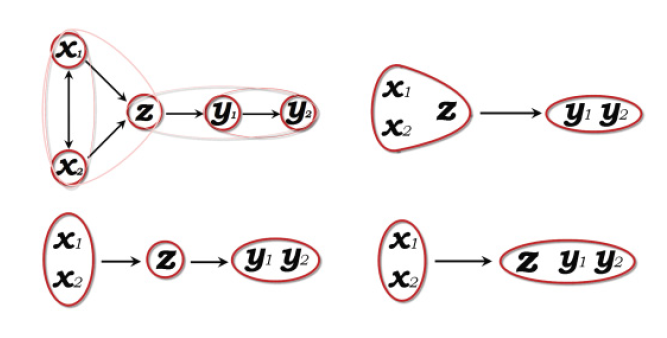

## Data preparations

In [28]:
samples = 2200
system = generateRandomVectorModel(samples=samples)
x1 = z_scorer(system[0])
x2 = z_scorer(system[1])
y1 = z_scorer(system[2])
y2 = z_scorer(system[3])
z = z_scorer(system[4])

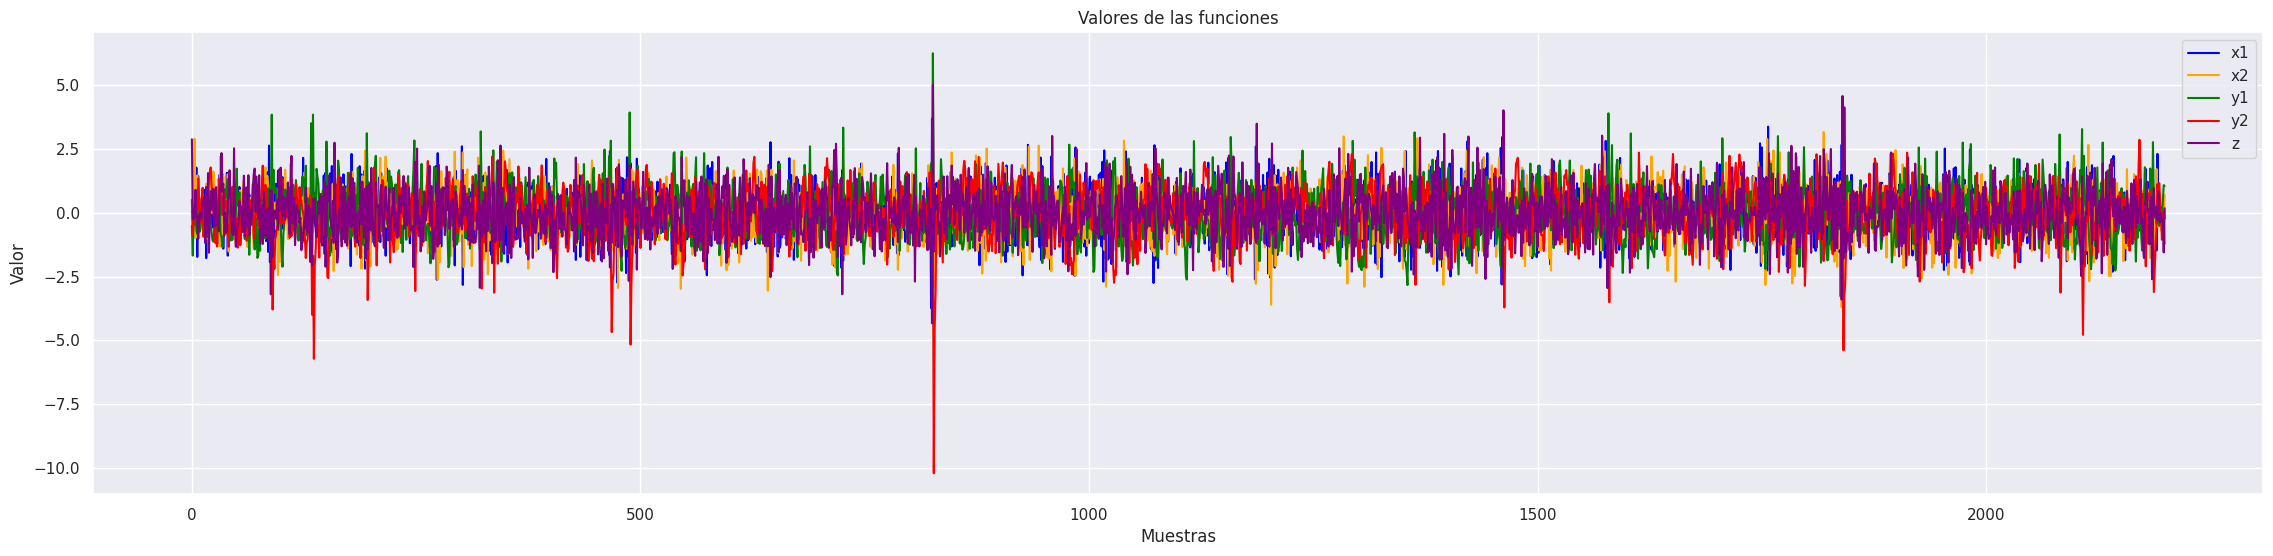

In [29]:
plt.figure(figsize=(28, 6))
plt.plot(x1, label='x1', color='blue')
plt.plot(x2, label='x2', color='orange')
plt.plot(y1, label='y1', color='green')
plt.plot(y2, label='y2', color='red')
plt.plot(z, label='z', color='purple')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.title('Valores de las funciones')
plt.legend()
plt.show()